# Dynamic Hand Gestures Classification

### version 2.3

#### Changelog

- version 2.3 - added right and double view to the already available "top" view. Split is again performed as in the paper.
- version 2.2 - strengthened data augmentation to make the classifier more robust to real-world gestures. Also removed the crop of the images to avoid losing too much information.
- version 2.1 - split is now performed as in the paper: 70/30 as it was before, but now datafiles 1-35 are assigned to training set, 36-50 to validation set.
- version 2.0 - now each finger in each hand is colored with a different color and tip traces follow this color pattern as well. Split is 70/30 but randomized, not sequential as in the paper.
- version 1.0 - first version: the two hands have a different colors and fingertips leave "temporal traces" of the trajectories they follow (but tip traces are red for both hands).


#### Paper: [Dynamic hand gesture recognition based on 3D patternassembled trajectories](https://hal.archives-ouvertes.fr/hal-01666377/document)

#### Dataset: [Dynamic Hand Gestures repository for LMDHG dataset](https://www-intuidoc.irisa.fr/en/english-leap-motion-dynamic-hand-gesture-lmdhg-database/)

#### Preprocessing: [Code to convert Dataset*.txt to hands images](https://gitlab.com/aviogit/dynamic-hand-gestures) (@ [commit 42e8a0d1](https://gitlab.com/aviogit/dynamic-hand-gestures/-/commit/42e8a0d1811075df93affb7d9ef9d54ccc6fc24e))

Generated images have no label embedded, left-right hands have different colors and now fingers are also colored differently (also between left/right hand) and fingertips follow the same colore scheme. Fingertips leave traces across the entire gesture (as defined and labeled in the original LMDHG dataset) fading linearly in the alpha channel. Only one view is used per gesture: "top" view.


<table>
    <tr>
        <td><center>Catching</center></td>
        <td><center>Rotating</center></td>
    </tr>
    <tr>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Catching-716-datafile29.png"></img>
        </td>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Rotating-12858-datafile11.png"></img>
        </td>
    </tr>
    <tr>
        <td><center>Scroll Finger</center></td>
        <td><center>Shaking</center></td>
    </tr>
    <tr>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Scroll-Finger-412-datafile36.png"></img>
        </td>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Shaking-418-datafile41.png"></img>
        </td>
    </tr>
</table>


In [1]:
# -----------------------------
# Make everything deterministic
# -----------------------------
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

cuda_training_device = 0

os.environ['CUDA_DEVICE_ORDER']    = 'PCI_BUS_ID'
print(os.environ['PYTHONPATH'])
os.environ['PYTHONPATH']           = ''
print(os.environ['PYTHONPATH'])

import numpy as np
a_random_image_number_modifier = np.random.randint(100)
np.random.seed(2)

from matplotlib.pyplot import imshow

import torch
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#%matplotlib notebook
%matplotlib inline

/cm/local/apps/cuda/libs/current/pynvml



In [2]:
import torch
import pycuda
from pycuda import gpuarray
from pycuda import compiler
from pycuda.curandom import rand as curand

# -----------------------------
# --- initialize the device ---
# -----------------------------
import pycuda.autoinit
import pycuda.driver as drv

drv.init()
print("%d device(s) found." % drv.Device.count())
           
for ordinal in range(drv.Device.count()):
    dev = drv.Device(ordinal)
    print (ordinal, dev.name())

print(torch.cuda.is_available())
print(torch.cuda.device_count())

2 device(s) found.
0 Tesla V100-PCIE-32GB
1 Tesla V100-PCIE-32GB
True
2


In [3]:
import torch
import sys
print('__Python VERSION:',  sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:',       torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ',     torch.cuda.device_count())
print ('Current cuda device ',   torch.cuda.current_device())

__Python VERSION: 3.6.7 (default, Apr 12 2019, 22:03:02) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-28)]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 7603
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


#### Choose the GPU for training

In [4]:
# Supposing we're training on the other, let's use the second available device...
torch.cuda.set_device('cuda:' + str(cuda_training_device))

print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ',     torch.cuda.device_count())
print ('Current cuda device ',   torch.cuda.current_device())

Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [5]:
import fastai
import pathlib

from fastai.vision import *
from fastai.metrics import error_rate
from fastai import __version__

from torchvision.models import vgg16_bn

import torchvision
from torchvision import models

from fastai.callbacks import *
from fastai.utils import show_install

In [6]:
!nvidia-smi

Fri Feb 21 12:18:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   36C    P0    37W / 250W |    316MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
show_install(0)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 2
torch devices : 2
  - gpu0      : 32480MB | Tesla V100-PCIE-32GB
  - gpu1      : 32480MB | Tesla V100-PCIE-32GB

=== Environment === 
platform      : Linux-3.10.0-957.1.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core
distro        : CentOS Linux 7 Core
conda env     : Unknown
python        : /home/ranieri/ml/bin/python3
sys.path      : /cm/local/apps/cuda/libs/current/pynvml
/home/ranieri/ml/lib/python36.zip
/home/ranieri/ml/lib/python3.6
/home/ranieri/ml/lib/python3.6/lib-dynload
/cm/local/apps/python3/lib/python3.6

/home/ranieri/ml/lib/python3.6/site-packages
/home/ranieri/Ranger-Deep-Learning-Optimizer
/home/ranieri/ml/lib/python3.6/site-packages/IPython/extensions
/home/ranieri/.ipython
```

Please make sure to include opening/closing ``` w

In [8]:
print(f'Fast.ai version: {fastai.__version__}')

Fast.ai version: 1.0.60


#### A few utilities functions...

In [9]:
from subprocess import check_output
nvidia_smi_ = [0, 0]

def get_num_gpus(debug=False):
    # torch.cuda.device_count() works strange :)
    n_gpus = check_output(['nvidia-smi', '--list-gpus']).decode('UTF-8').count('\n')
    if debug:
        print(n_gpus)
    return int(n_gpus)

def get_gpus_vram_stats(id=0, debug=False):
    n_gpus = get_num_gpus(debug)
    mem_stats = check_output(['nvidia-smi', '--id='+str(id), '--query-gpu=memory.total,memory.free,memory.used', '--format=csv,noheader']).decode('UTF-8').split() #.count('\n')
    mem_total = mem_stats[0]
    mem_free  = mem_stats[2]
    mem_used  = mem_stats[4]
    if debug:
        print(n_gpus)
        print(mem_stats)
        print(mem_total)
        print(mem_free)
        print(mem_used)
    return int(mem_total), int(mem_free), int(mem_used)
    
def nvidia_smi(nvidia_smi_, gpu_num=0, debug=False):
    old_nvidia_smi_ = nvidia_smi_[1]
    nvidia_smi_now  = check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']).decode('UTF-8')
    nvidia_smi_now_gpus = nvidia_smi_now.splitlines()
    if debug:
        print(nvidia_smi_now_gpus)
    for i in range(get_num_gpus()):
        if i == gpu_num:
            nvidia_smi_[0]  = int(nvidia_smi_now_gpus[i])
            nvidia_smi_[1]  = int(nvidia_smi_now_gpus[i]) - old_nvidia_smi_
    return nvidia_smi_ 

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))

torch.cuda.empty_cache()

nvidia-smi memory usage/increment: [316, 316]


## Build the DataBunch and create the Learner object

In [10]:
dataset_dir = Path('/home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper')
!ls -lh '{dataset_dir}'

total 1.5K
drwxr-xr-x  2 ranieri imati  1 Feb 20 16:36 models
drwxr-xr-x 16 ranieri imati 14 Feb 20 12:20 train
drwxr-xr-x 16 ranieri imati 14 Feb 20 12:28 valid


In [11]:
arch_str      = "resnet-50"
default_size  = (1080, 1920)
if arch_str == "resnet-34":
    cnn_model = models.resnet34
    img_size  = [int(x/10) for x in default_size]
    epochs    = 10
    bs        = 64
    # bs      = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
else:
    cnn_model = models.resnet50
    img_size  = [int(x/10) for x in default_size]
    epochs    = 10
    bs        = 64
    #bs       = 4   # uncomment this line if you run out of memory even after clicking Kernel->Restart

This is are the default values passed to `get_transforms()`:

`def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                    max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                    p_lighting:float=0.75,
                    xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:`

Pay also attention to the fact that, when you pass a single value as `size` when building your databunch, your images will be cropped.

In [12]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=25., max_zoom=1.5, max_lighting=0.5,
                      max_warp=0.1, p_affine=0.75, p_lighting=0.75)

In [13]:
def create_dataset(bs, image_size=default_size, tfms=tfms):
    #tfms = get_transforms()
    #ll = ImageList.from_folder(dataset_dir).split_by_rand_pct(0.3).label_from_folder()
    ll = ImageList.from_folder(dataset_dir).split_by_folder().label_from_folder()
    
    data = (ll.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=bs)).normalize(imagenet_stats)

    data.show_batch(rows=3, figsize=(7,6))

    print(f'The dataset has {len(data.classes)} ({data.c}) classes: {data.classes}')
    print(f'Training   set len is: (x: {len(data.train_dl.dl.dataset.x)}, y: {len(data.train_dl.dl.dataset.y)})')
    print(f'Validation set len is: (x: {len(data.valid_dl.dl.dataset.x)}, y: {len(data.valid_dl.dl.dataset.y)})')
    print(f'Dataset image size is  (train: {data.train_dl.dl.dataset.x[0].size}, valid: {data.valid_dl.dl.dataset.x[0].size})')
    
    return data

In [14]:
def show_augmented_images():
    this_batch = data.one_batch()
    this_batch_images = this_batch[0]
    this_batch_labels = this_batch[1]
    print(f'Batch  shape: {this_batch_images.shape}')
    print(f'Image  shape: {this_batch_images[0].shape}')
    print(f'Labels shape: {this_batch_labels.shape}')
    print(f'Label[0]: {this_batch_labels[0]} -> {data.classes[this_batch_labels[0]]}')
    Image(this_batch_images[0]).show(figsize=(11,11))
    print(f'Label[2]: {this_batch_labels[2]}')
    Image(this_batch_images[2]).show(figsize=(11,11))

In [15]:
def get_random_img(data):
    rnd_idx = np.random.randint(len(data.train_dl.dl.dataset.x))
    img   = data.train_dl.dl.dataset.x[rnd_idx]
    label = data.train_dl.dl.dataset.y[rnd_idx]
    print(label, img.size)
    return img, label

def plot_random_augmented_image(data, rows, cols, width, height, **kwargs):
    resize_method = ResizeMethod.SQUISH
    for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten()):
        img_tuple = get_random_img(data)
        #print(type(img_tuple[0]), img_tuple[0].shape)
        #print(type(img_tuple[1]), img_tuple[1])
        img_tuple[0].apply_tfms(tfms[0], resize_method=resize_method, **kwargs).show(ax=ax, title=f'{img_tuple[1]}')

In [16]:
print(f'Performing data augmentation applying {len(tfms[0])} transforms:\n\n{tfms[0]}')
for i in tfms[0]:
    print(20*'-')
    print(i)
    print(20*'-')

Performing data augmentation applying 7 transforms:

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.1, 0.1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-25.0, 25.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.5), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.25, 0.75)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (contrast), kwargs={'sca

In [17]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


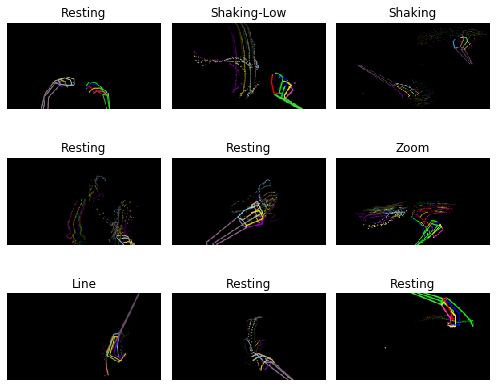

In [18]:
data = create_dataset(bs, img_size)

Resting torch.Size([2160, 1920])
Resting torch.Size([1080, 1920])
Resting torch.Size([1080, 1920])
Pointing torch.Size([2160, 1920])
Resting torch.Size([2160, 1920])
Catching-hands-up torch.Size([2160, 1920])
Resting torch.Size([1080, 1920])
Resting torch.Size([1080, 1920])
Resting torch.Size([1080, 1920])
Resting torch.Size([1080, 1920])
C torch.Size([2160, 1920])
Resting torch.Size([1080, 1920])


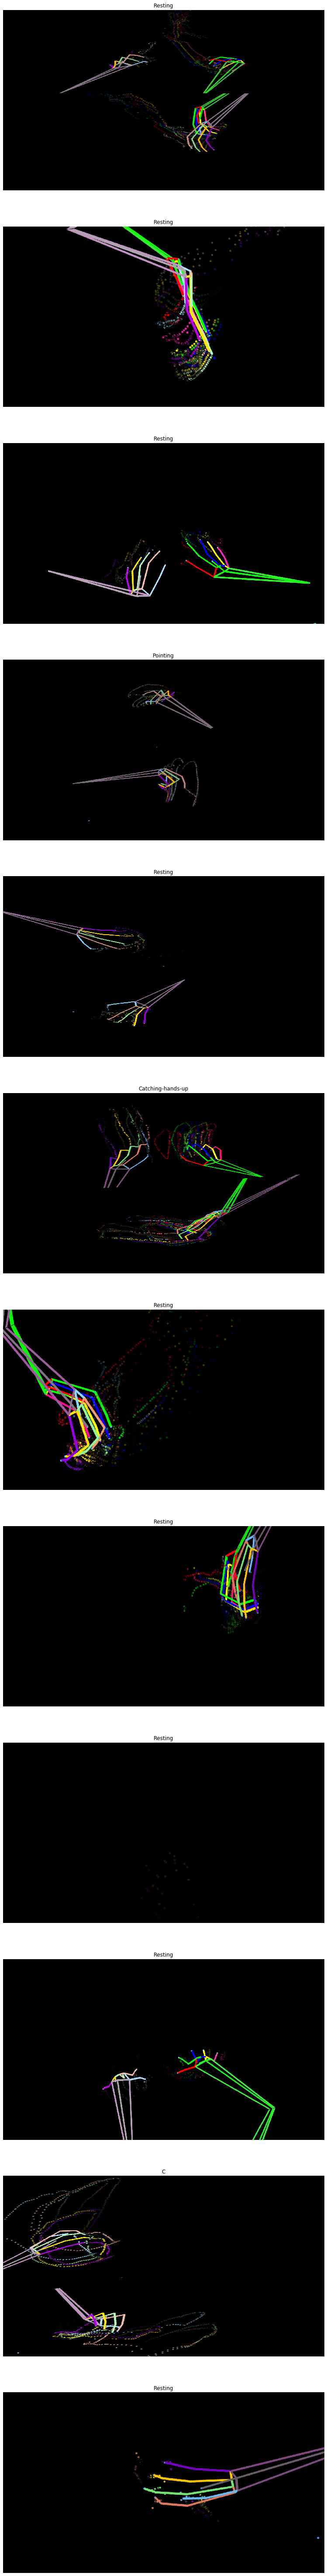

In [19]:
plot_random_augmented_image(data, 12, 1, 192, 108, size=(1080, 1920))

Batch  shape: torch.Size([64, 3, 108, 192])
Image  shape: torch.Size([3, 108, 192])
Labels shape: torch.Size([64])
Label[0]: 9 -> Shaking
Label[2]: 6


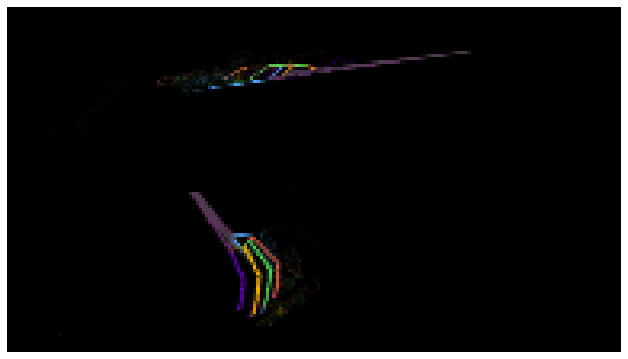

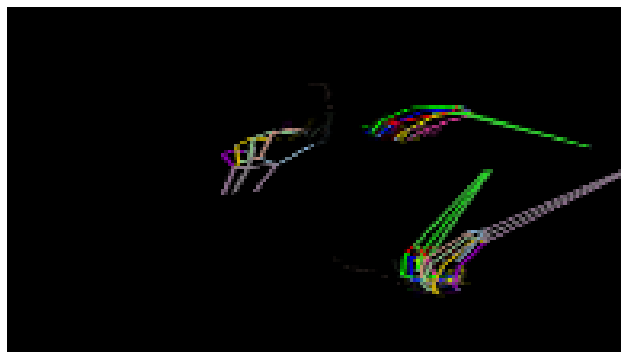

In [20]:
show_augmented_images()

In [21]:
from datetime import datetime
currtime = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

runtime_name = 'local'

if runtime_name   == 'local':
  savepath           = dataset_dir / '..' / 'models'
elif runtime_name == 'colab':
  savepath           = Path(base_path) / dataset_dir / 'models'
else:
  savepath           = Path('/tmp')

savepath.mkdir(exist_ok=True)

model_name = arch_str

print(f'Models will be saved at: {savepath} with name: {model_name}')

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))

learn = cnn_learner(data, cnn_model, metrics=accuracy)

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
print('Learner ready.')

Models will be saved at: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models with name: resnet-50
nvidia-smi memory usage/increment: [1443, 1127]
nvidia-smi memory usage/increment: [1499, 372]
Learner ready.


Catching torch.Size([1080, 1920])


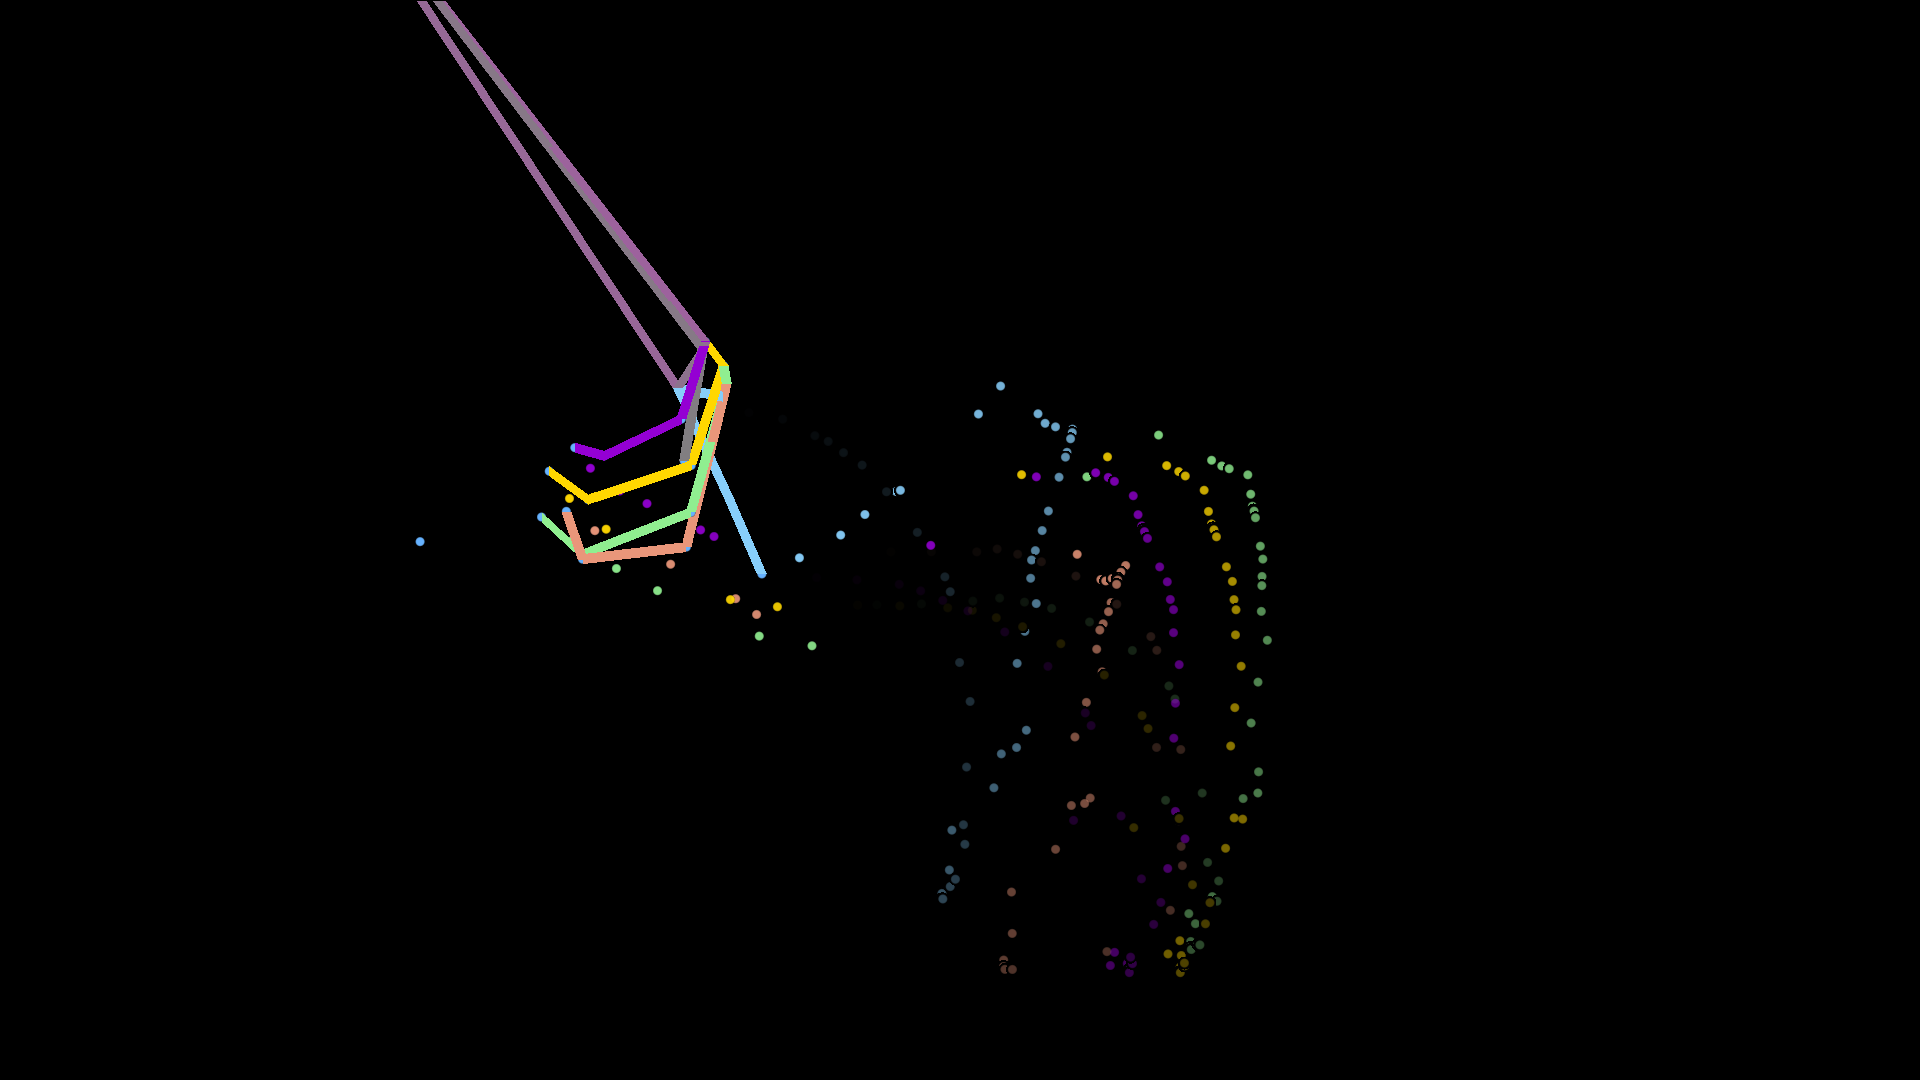

In [22]:
rnd_idx = np.random.randint(len(data.train_dl.dl.dataset.x))
img   = data.train_dl.dl.dataset.x[rnd_idx]
label = data.train_dl.dl.dataset.y[rnd_idx]
print(label, img.size)
img

Catching torch.Size([1080, 1920])


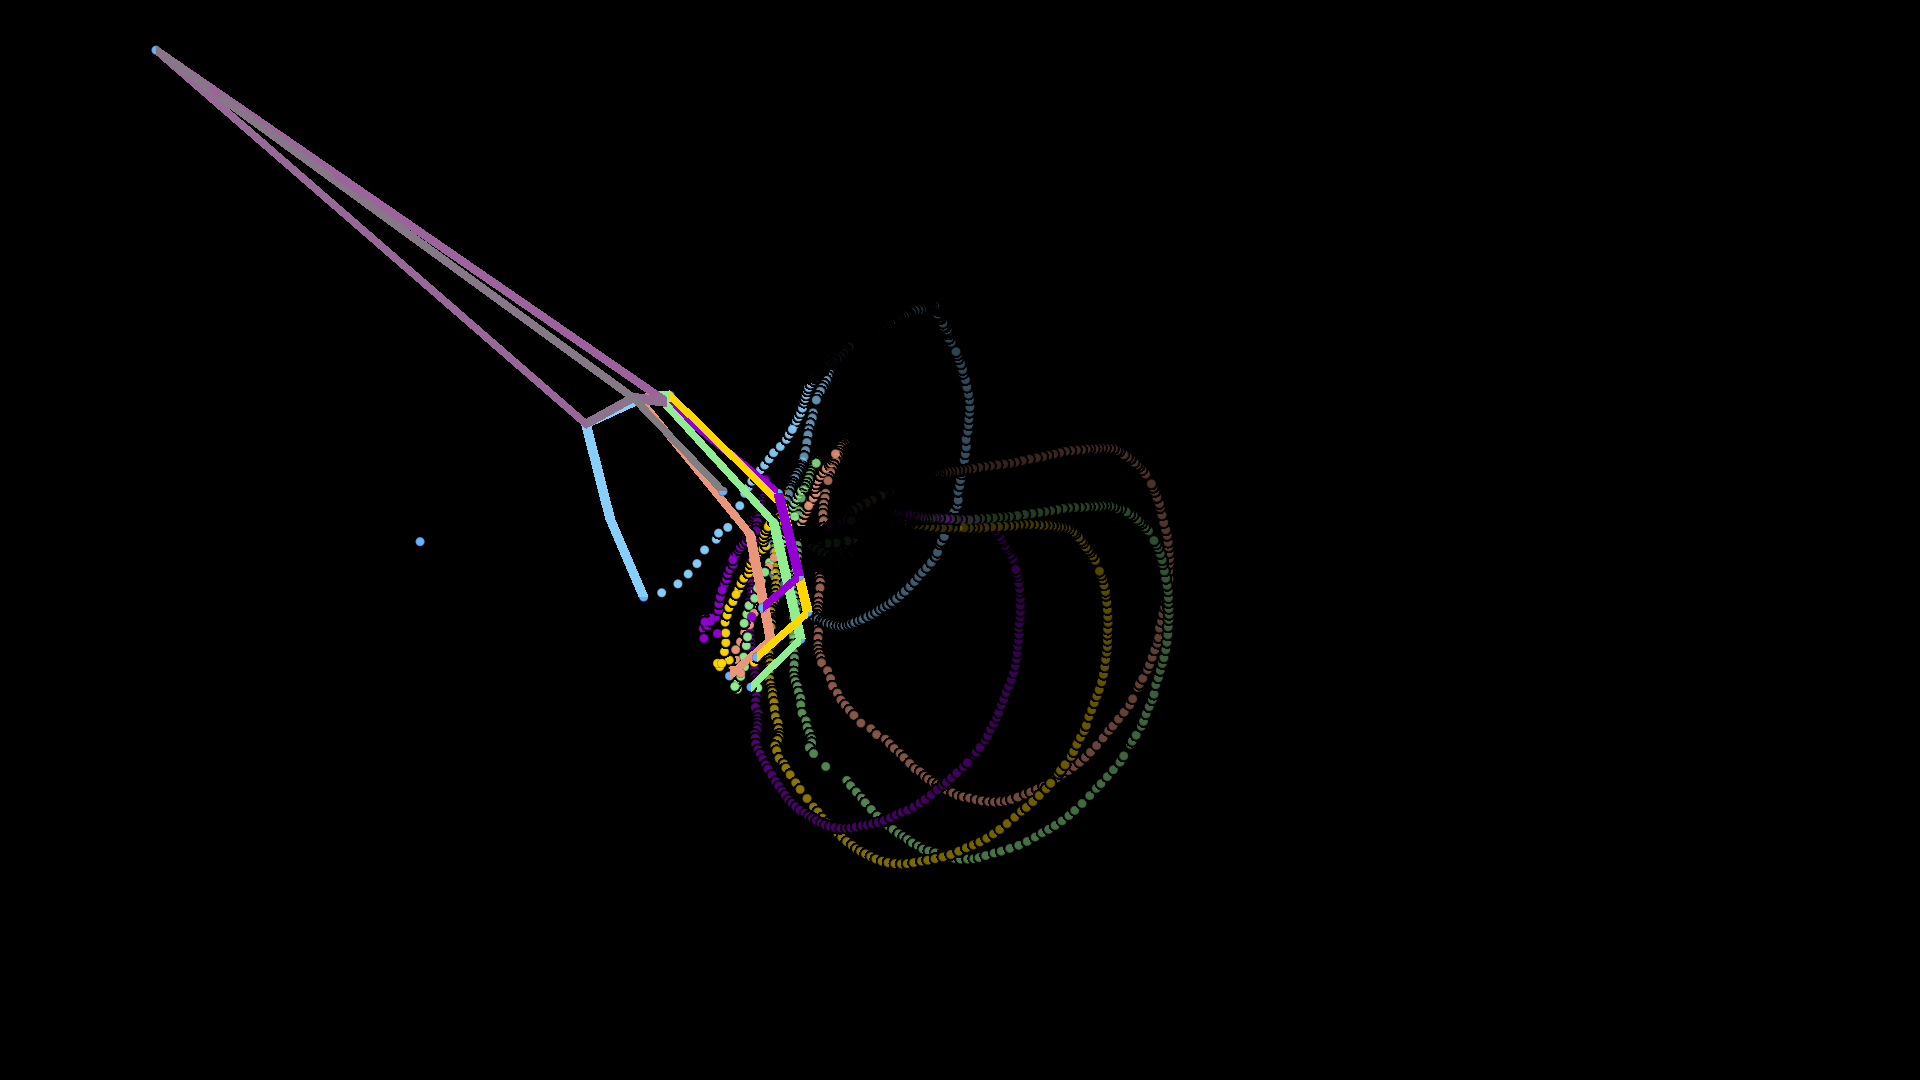

In [23]:
rnd_idx = np.random.randint(len(data.valid_dl.dl.dataset.x))
img   = data.valid_dl.dl.dataset.x[rnd_idx]
label = data.valid_dl.dl.dataset.y[rnd_idx]
print(label, img.size)
img

In [24]:
lr=1e-2

In [25]:
if runtime_name == 'colab':
    !bash -c 'if ! [ -d "/content/Ranger-Deep-Learning-Optimizer" ] ; then git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer ; cd Ranger-Deep-Learning-Optimizer ; ls -l ; pwd ; pip install -e . ; wget "https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py" ; else echo "/content/Ranger-Deep-Learning-Optimizer" already exists... ; fi'
!pip show ranger

Name: ranger
Version: 0.0.1
Summary: Ranger - a synergistic optimizer using RAdam (Rectified Adam) and LookAhead in one codebase 
Home-page: UNKNOWN
Author: Less Wright
Author-email: UNKNOWN
License: Apache
Location: /home/ranieri/Ranger-Deep-Learning-Optimizer
Requires: torch
Required-by: 


In [26]:
def show_hyperparams():
    print(f'Batch size: {bs}, image size: {img_size}, learning rate: {lr}')

In [27]:
def is_frozen(learn, debug=False):
    for child in learn.model.children():
        #print(child)
        for param in child.parameters():
            if debug:
                print(param.requires_grad)
            if param.requires_grad == False:
                return True, 'a'
    return False, 'b'

In [28]:
class SaveBestAccuracyCallback(TrackerCallback):
    "A `TrackerCallback` that stops the training when the accuracy reaches the desired level."
    def __init__(self, learn:Learner, save_str:str='best-accuracy-model'):
        super().__init__(learn, monitor='accuracy', mode='auto')
        self.prev_acc = 0.0
        self.save_str = save_str
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Check the monitored value and save the model if above prev_acc."
        current = self.get_monitor_value()
        print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
        if current is not None and self.operator(current, self.prev_acc):
            print(f'Accuracy {current} is above previous accuracy {self.prev_acc} at epoch {epoch}. Saving model...')
            self.prev_acc = current
            self.learn.save(f'{self.save_str}-acc-{current}-epoch-{epoch}')

In [29]:
def do_fit_fc(save_name, epochs=10, lr=defaults.lr, start_pct=0.3):
    savepath.mkdir(exist_ok=True)
    
    save_str = str(savepath) + '/' + model_name + '-img_size-' + '-'.join(str(x) for x in img_size) + '-' + save_name + '-' + currtime
    print(f'Learner object has path in: {learn.path} (which can be readonly, so we need to change it...)')
    learn.path = savepath
    print(f'Learner object new path is: {learn.path}')
    
    print(f'Saving models with prefix: {save_str}')
    
    reduce_lr_callback    = ReduceLROnPlateauCallback(learn, monitor='train_loss', patience=2, factor=0.2, min_delta=0)
    save_callback         = SaveModelCallback(learn, every='epoch', monitor='accuracy', name=save_str)
    #tracker_callback      = TrackerCallback(learn, monitor='feat_12')
    #stop_acc_callback     = StopAtThisAccuracyCallback(learn, value=0.999)
    save_best_callback    = SaveBestAccuracyCallback(learn, save_str=save_str)
    tensorboard           = None
    if tensorboard:
        tboard_callback   = LearnerTensorboardWriter(learn, base_dir=tboard_path, name=save_str)
    else:
        tboard_callback   = None

    #callbacks             = [save_callback, reduce_lr_callback, stop_acc_callback, save_best_callback, tboard_callback]
    callbacks             = [save_callback, reduce_lr_callback]
    
    learn.fit_fc(epochs, lr, start_pct=start_pct, callbacks=callbacks)
    learn.save(save_str)
    
    print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
    learn.show_results(rows=3)

# Fast.ai doesn't provide an `evaluate()`-like function as in Keras

![alt text](https://i.ibb.co/86k8rFN/image.png)

So it's not possible to have a labeled test set in the same databunch used for training/validation of the model. Ok, let's follow the advice and build another databunch with training and test set (used as validation set). <spoiler> In Keras there's a handy [model.evaluate()](https://keras.io/models/model/#evaluate) function to test the model. </spoiler>

In [30]:
def evaluate_model_from_interp(interp, data):
  # perform a "manual" evaluation of the model to take a look at predictions vs. labels and to
  # re-compute accuracy from scratch (to double check and also because I didn't find a quick way
  # to extract accuracy inside the guts of Fast.ai after a call to validate() on the test set...)
  print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
  print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
  print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)

  print('')
  print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')

  ok_pred = 0

  for idx, raw_p in enumerate(interp.preds):
      pred = np.argmax(raw_p)
      if idx < 100000:
          print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
      if pred == interp.y_true[idx]:
          ok_pred += 1

  acc = ok_pred / len(interp.y_true)
  print(f'Overall accuracy of the model: {acc:0.5f}')
  return acc

# Training

## Round 1 - 192x108px

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


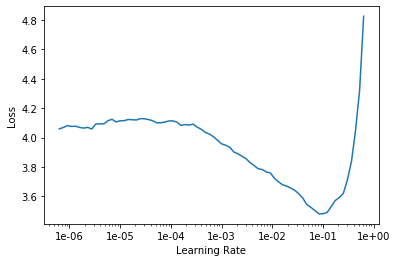

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
show_hyperparams()

Batch size: 64, image size: [108, 192], learning rate: 0.01


In [33]:
train_round=1
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[108, 192]-1a-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [3900, 3833]


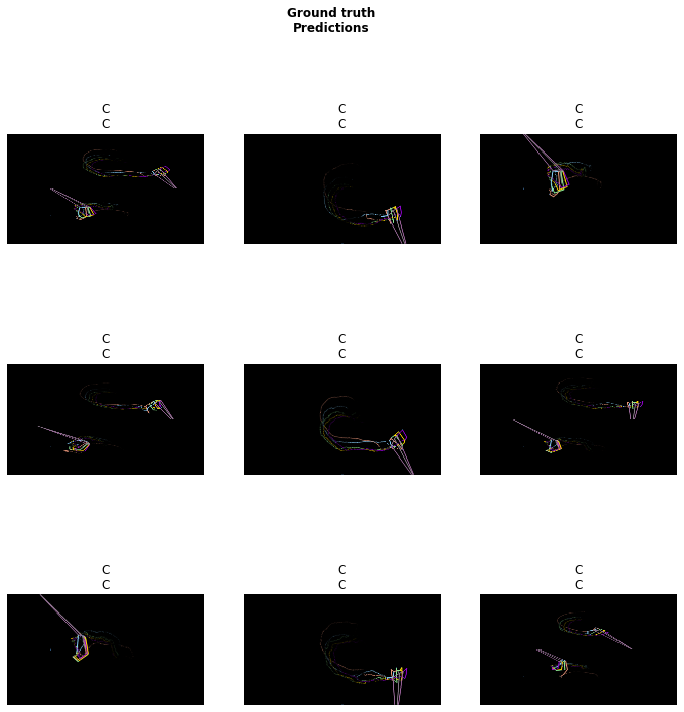

In [34]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [35]:
train_round=1
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


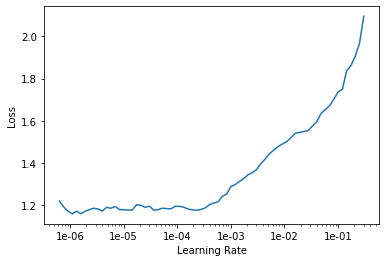

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
lr=1e-4

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[108, 192]-1b-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [4284, 451]


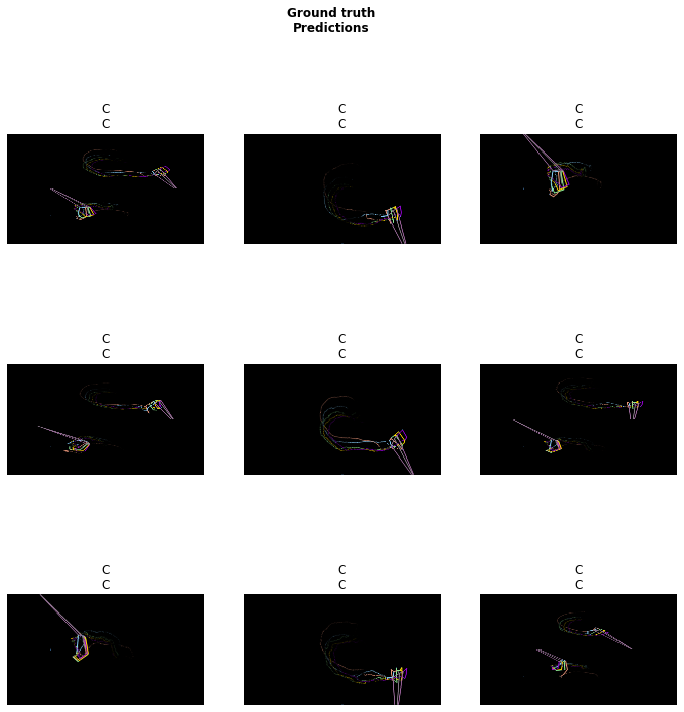

In [38]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Interpreting results and plotting top losses for stage-1


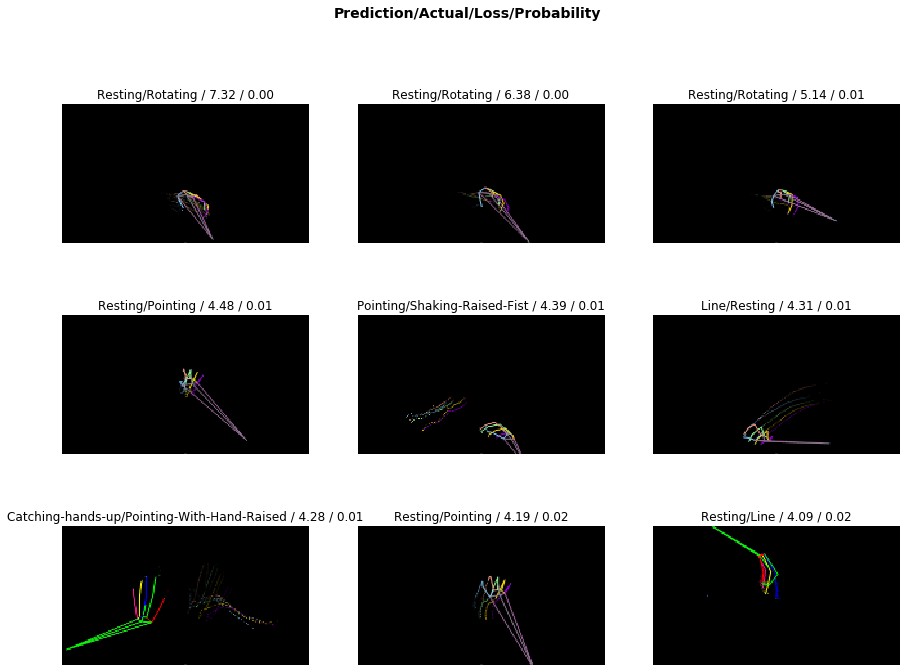

In [39]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-1


[('Pointing-With-Hand-Raised', 'Pointing', 18),
 ('Rotating', 'Resting', 13),
 ('Zoom', 'Resting', 9),
 ('Shaking-Raised-Fist', 'Shaking-Low', 8),
 ('Catching-hands-up', 'Catching', 7),
 ('Pointing', 'Resting', 7),
 ('Resting', 'Pointing', 7),
 ('Line', 'Resting', 6),
 ('Shaking-Raised-Fist', 'Resting', 6),
 ('Zoom', 'Line', 5),
 ('Pointing-With-Hand-Raised', 'Catching-hands-up', 3),
 ('Pointing-With-Hand-Raised', 'Line', 3),
 ('Resting', 'C', 3),
 ('Resting', 'Line', 3),
 ('Shaking-Raised-Fist', 'Shaking', 3),
 ('Catching', 'Catching-hands-up', 2),
 ('Line', 'Zoom', 2),
 ('Resting', 'Shaking-Low', 2),
 ('Resting', 'Slicing', 2),
 ('Rotating', 'Shaking', 2)]

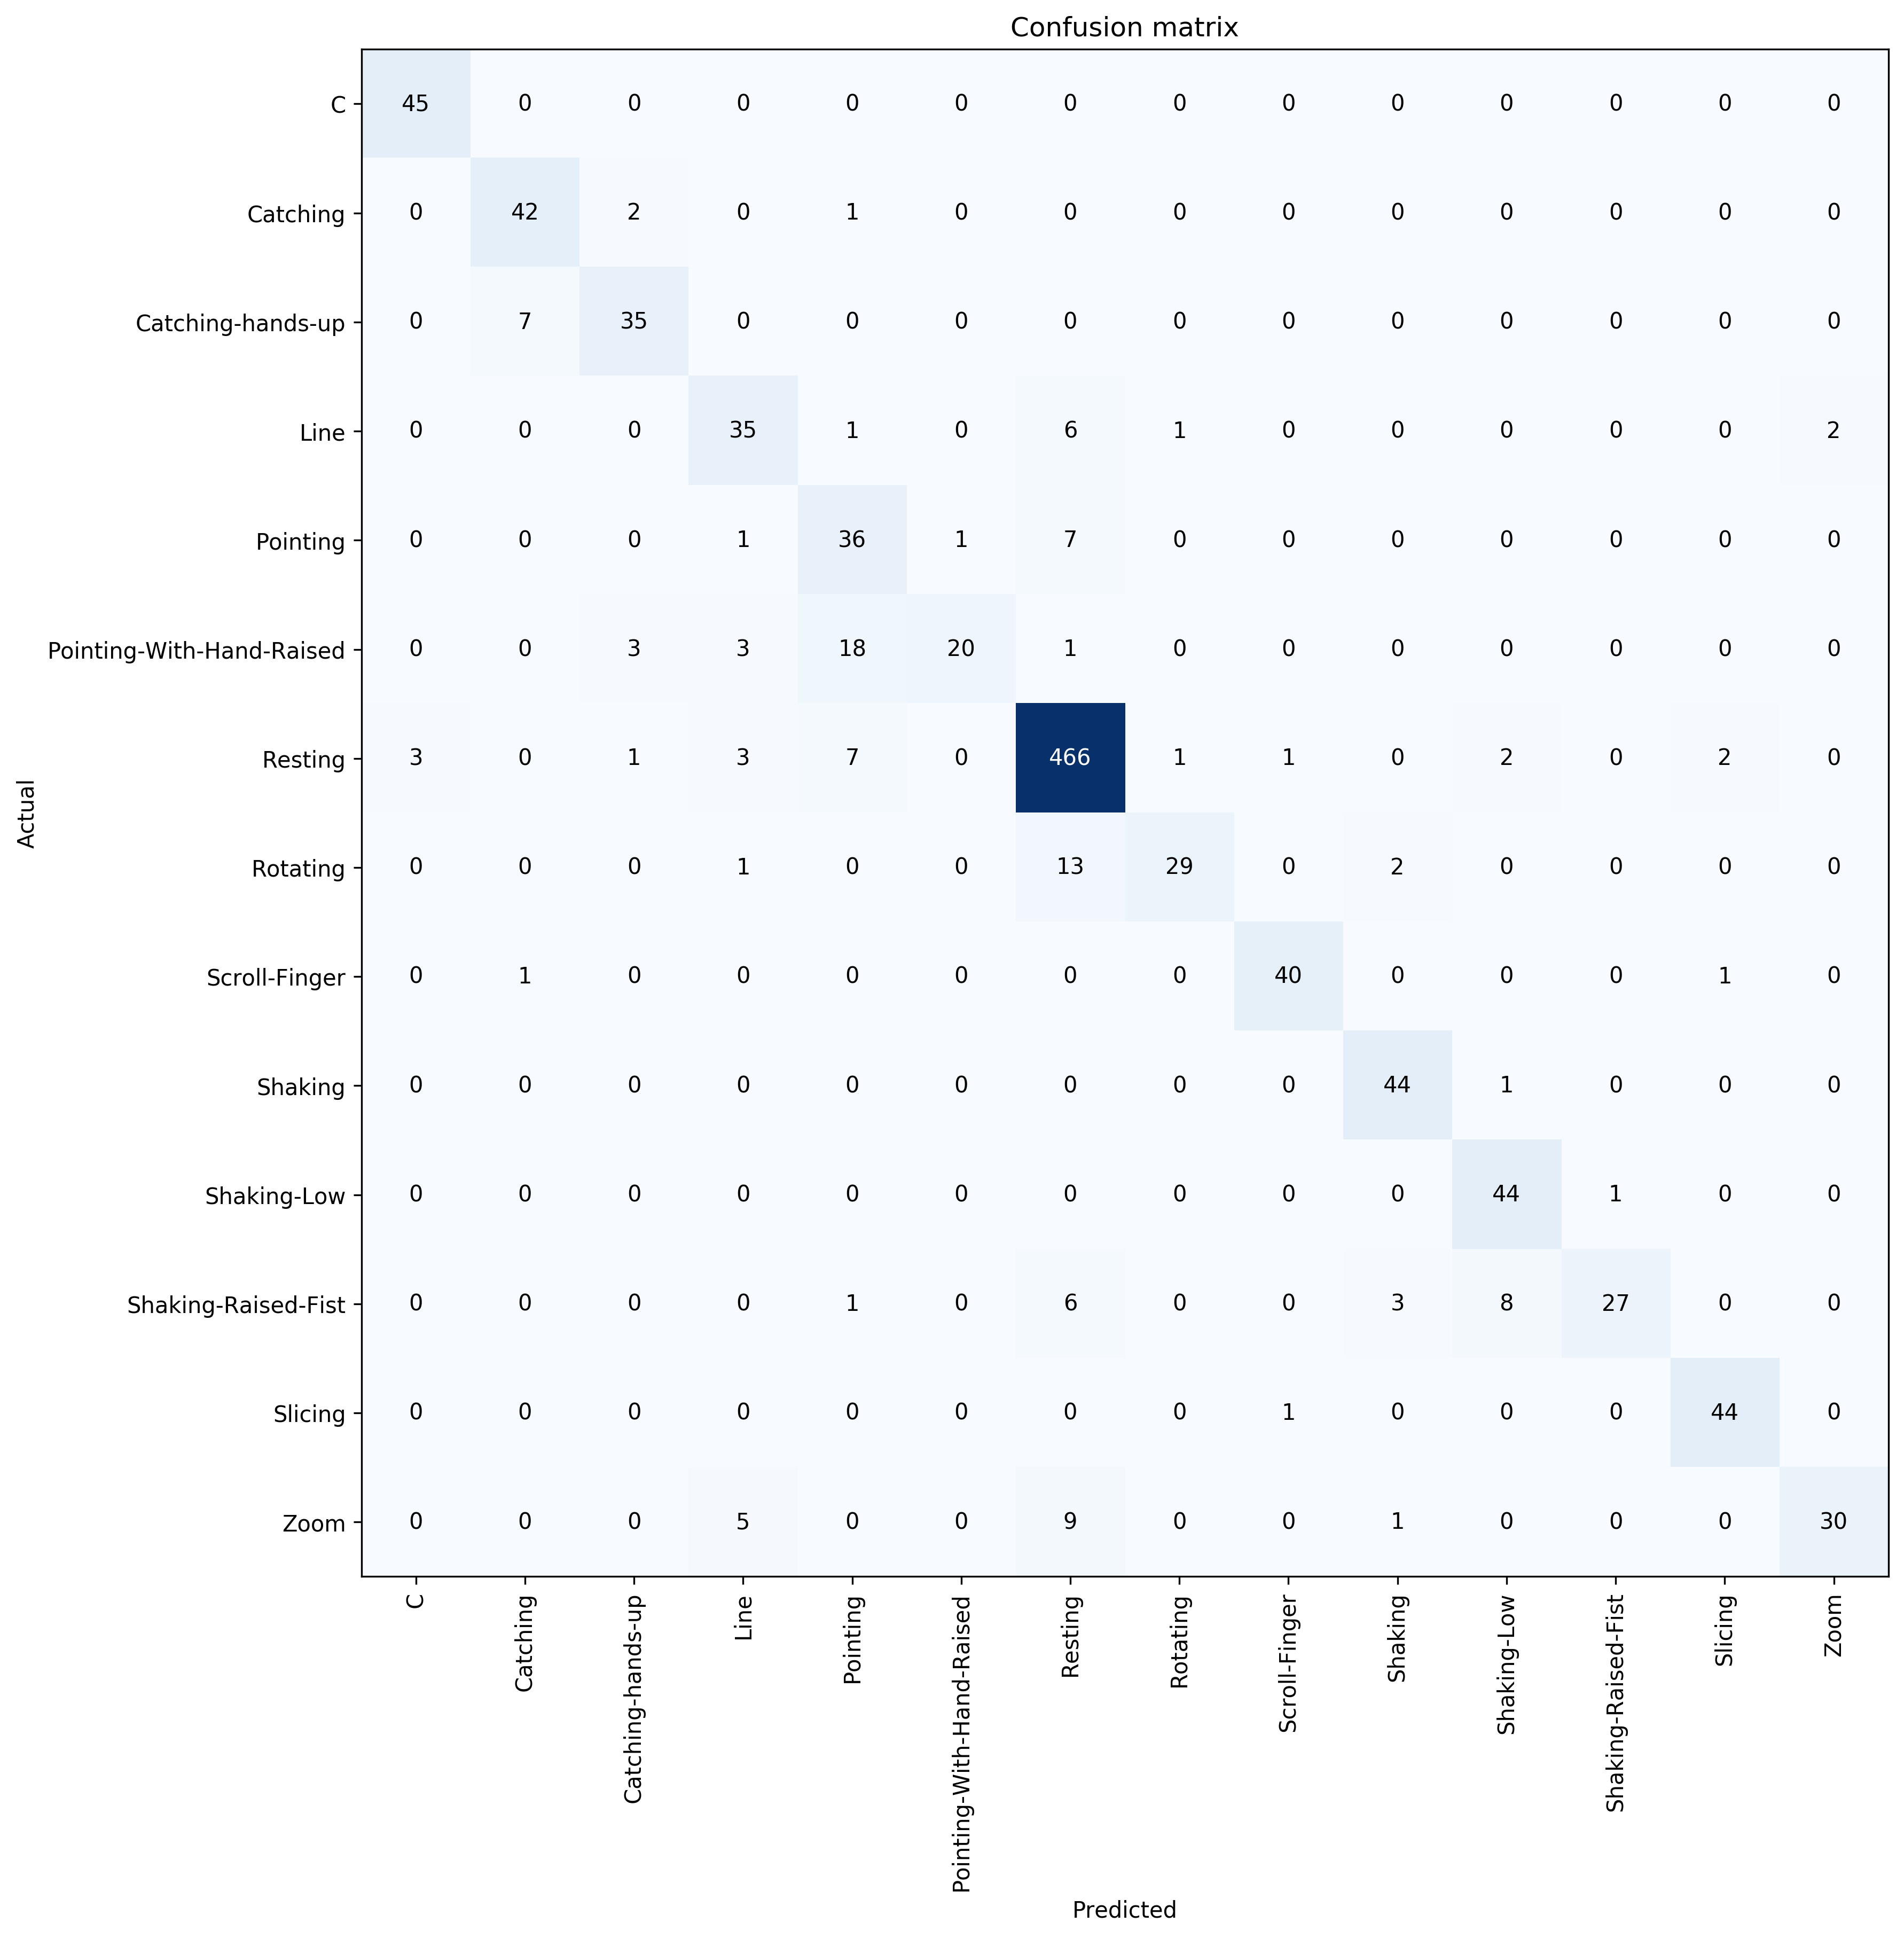

In [40]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-1


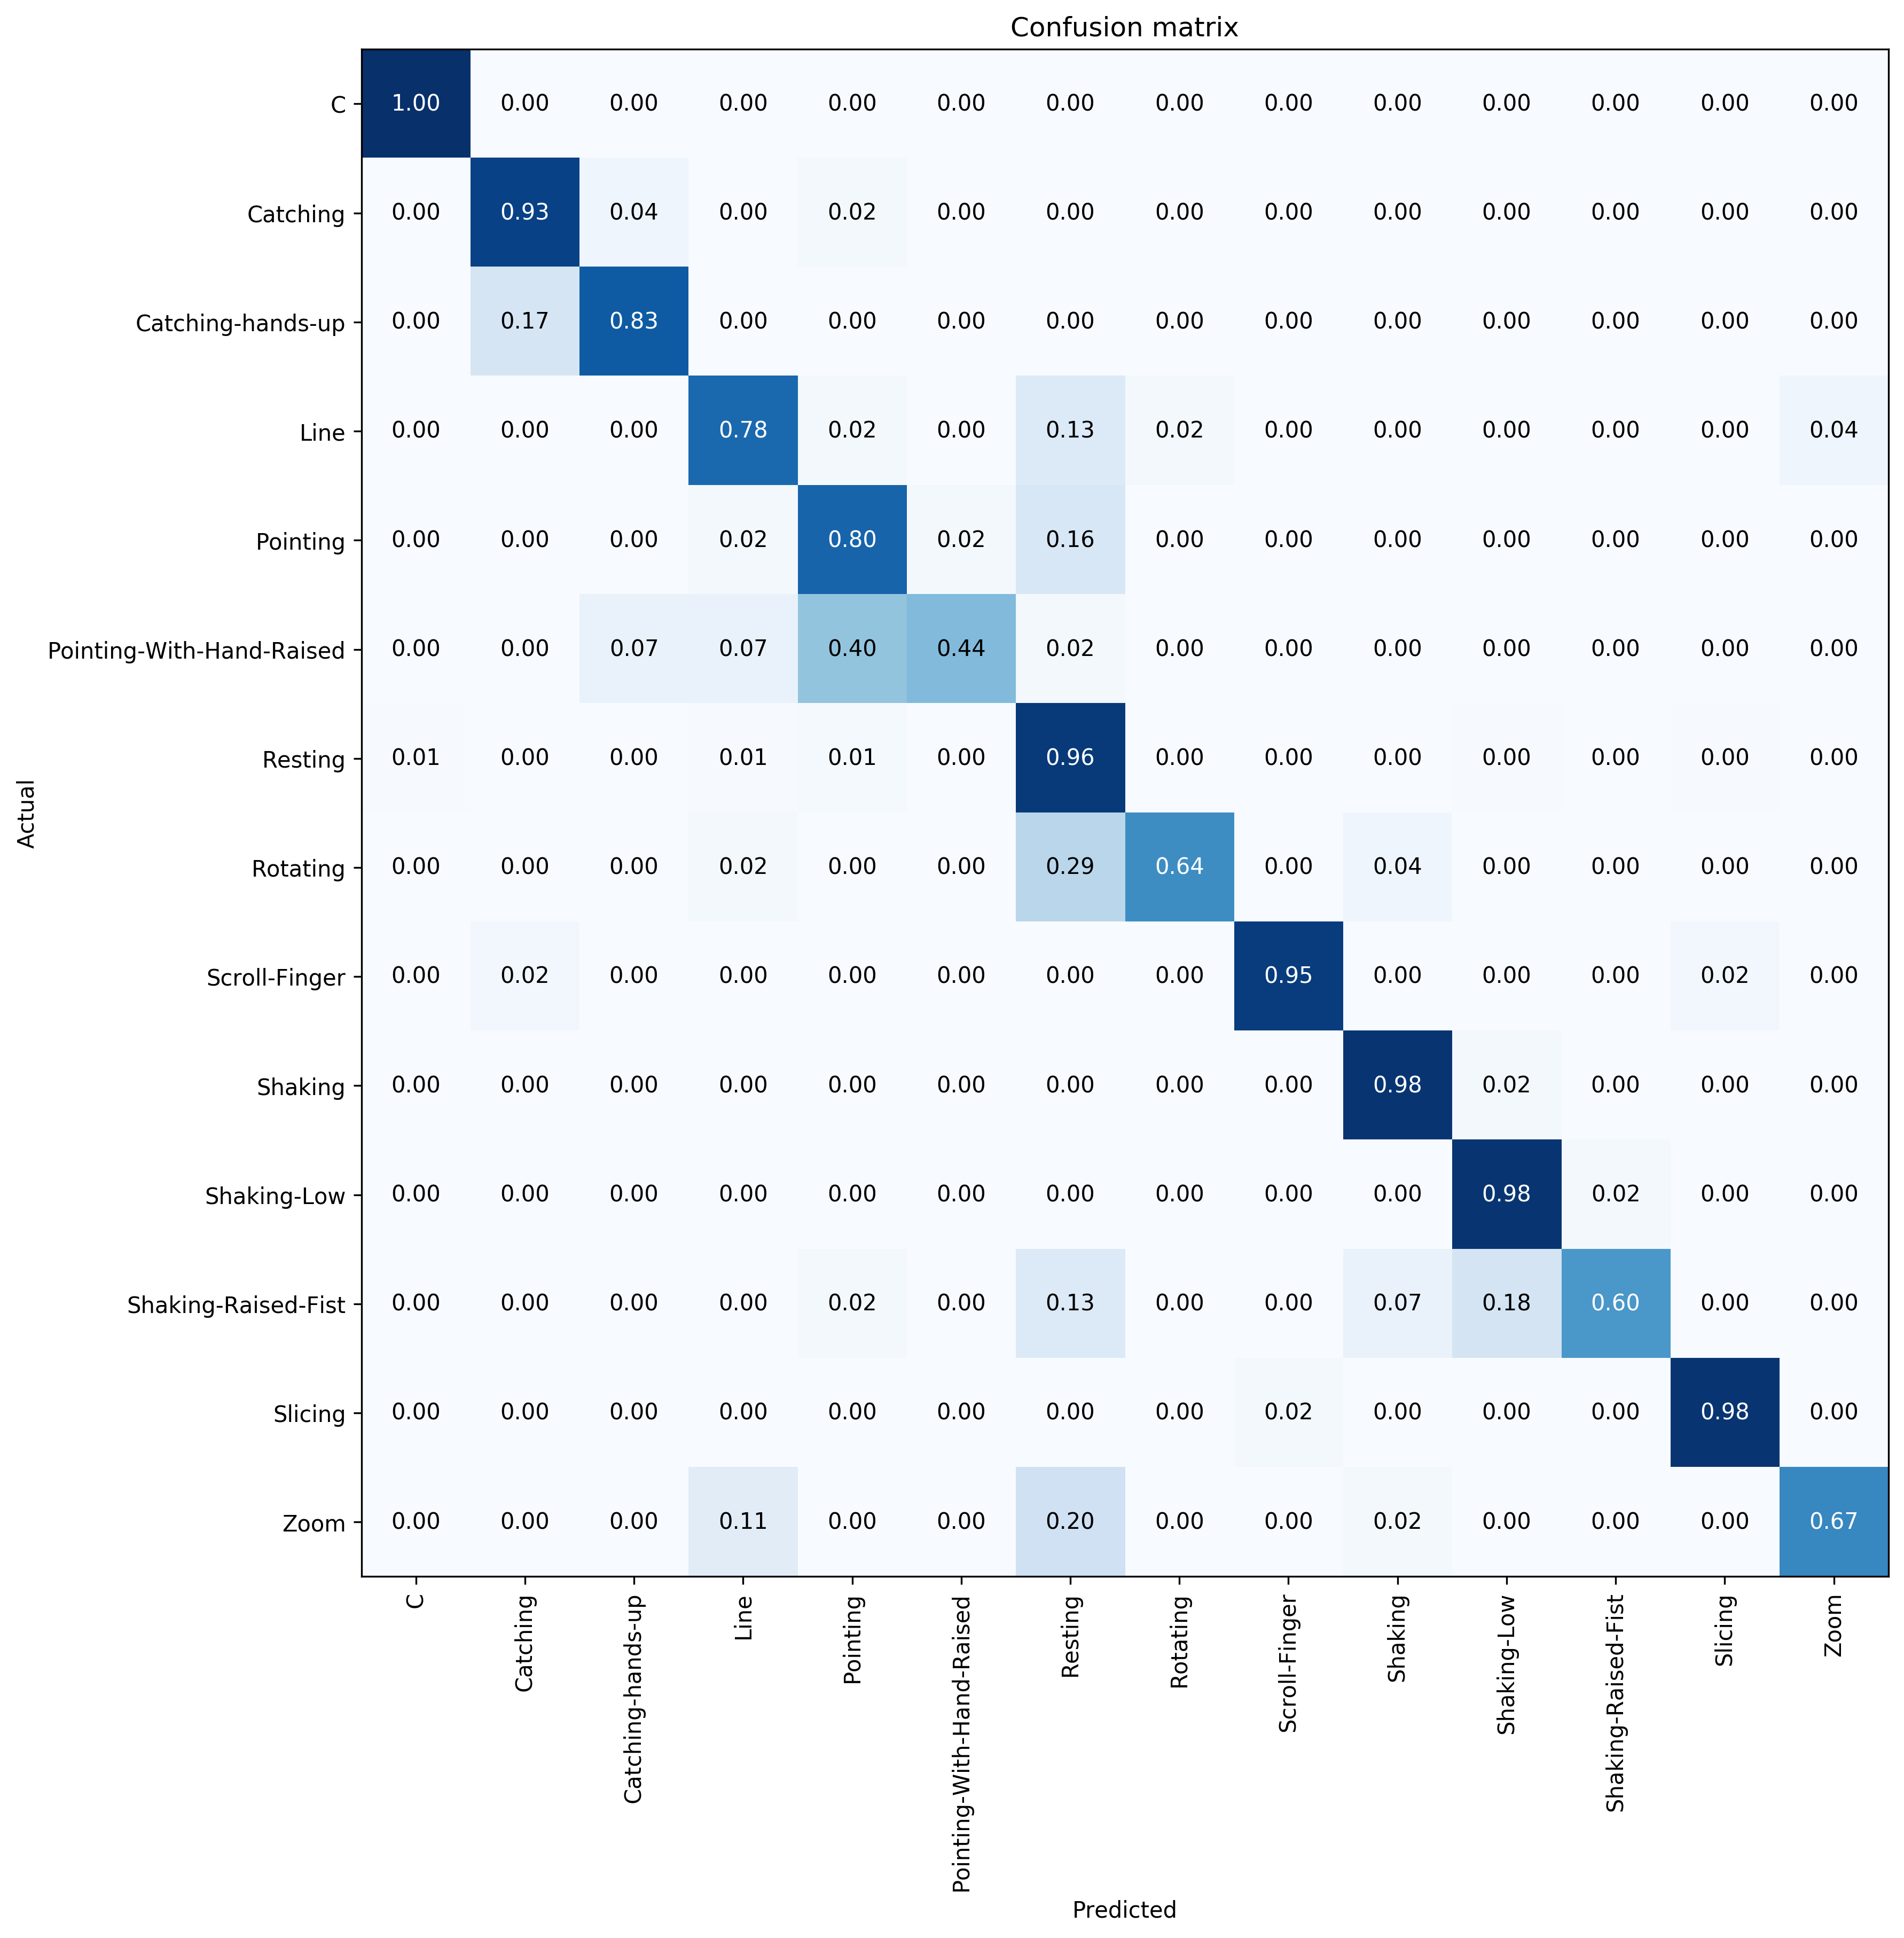

In [41]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [42]:
acc = evaluate_model_from_interp(interp, data)

Interp has 1065 ground truth labels: tensor([ 0,  0,  0,  ..., 13, 13, 13])
Interp yielded 1065 raw predictions. First two raw predictions are: tensor([[9.9812e-01, 1.5467e-04, 3.4985e-05, 1.5542e-04, 2.4700e-04, 4.8539e-06,
         4.7444e-05, 1.3778e-05, 1.0501e-03, 4.1308e-06, 9.6902e-05, 1.3080e-05,
         4.8152e-05, 7.8380e-06],
        [9.9924e-01, 4.5504e-04, 5.6526e-05, 2.1320e-05, 4.4376e-05, 2.0935e-06,
         4.5466e-05, 1.4849e-06, 7.7425e-05, 8.7510e-07, 3.0953e-05, 6.8171e-06,
         9.1020e-06, 4.6361e-06]])
The problem had 14 classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C -> C
0 -> 0 = C

6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
12 -> 6 = Slicing -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting -> Resting
6 -> 6 = Resting ->

## Round 2 - 384x216px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


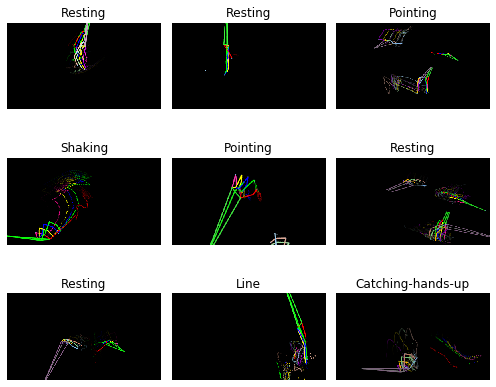

In [43]:
bs=64
img_size=[int(x/5) for x in default_size] # 384x216
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([64, 3, 216, 384])
Image  shape: torch.Size([3, 216, 384])
Labels shape: torch.Size([64])
Label[0]: 13 -> Zoom
Label[2]: 9


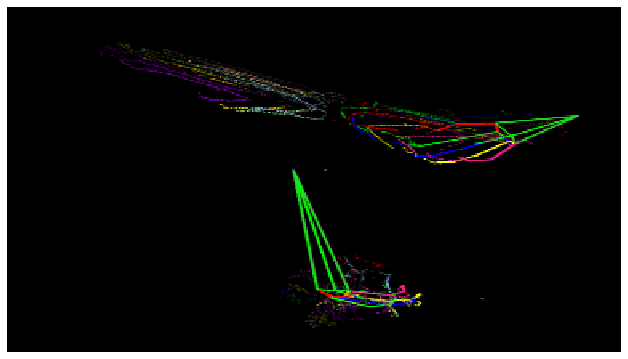

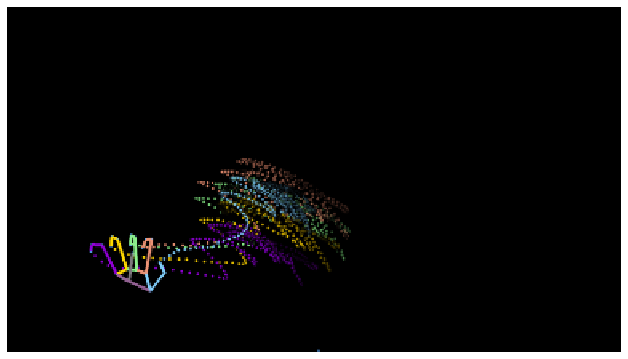

In [44]:
show_augmented_images()

In [45]:
show_hyperparams()

Batch size: 64, image size: [216, 384], learning rate: 0.0001


In [46]:
train_round=2
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


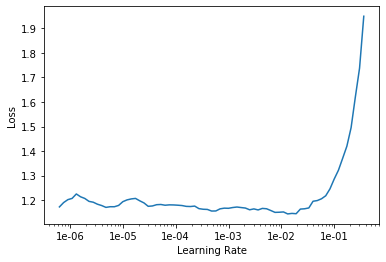

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
lr=5*1e-3

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[216, 384]-2a-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [11902, 11451]


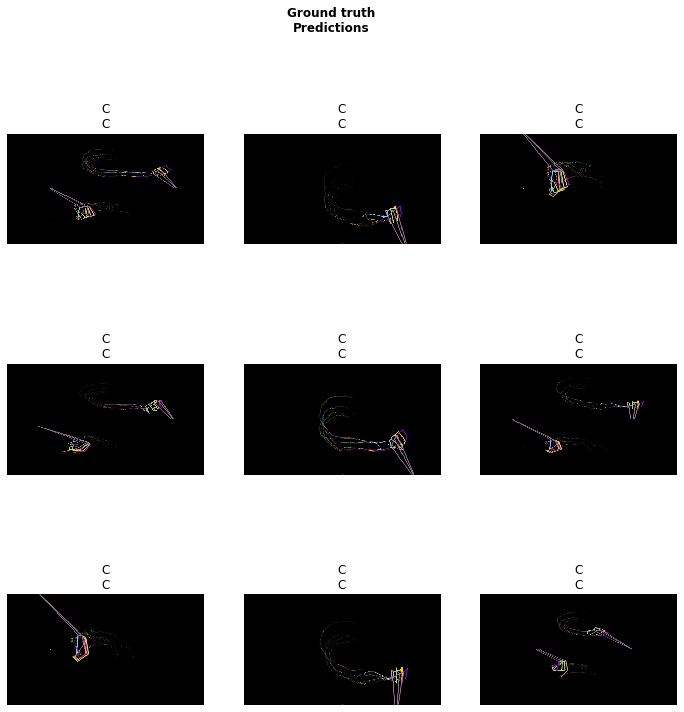

In [49]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [50]:
train_round=2
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


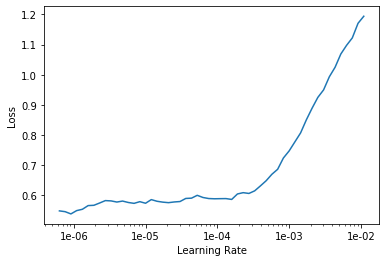

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
lr=1e-4

In [53]:
show_hyperparams()

Batch size: 64, image size: [216, 384], learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[216, 384]-2b-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [12450, 999]


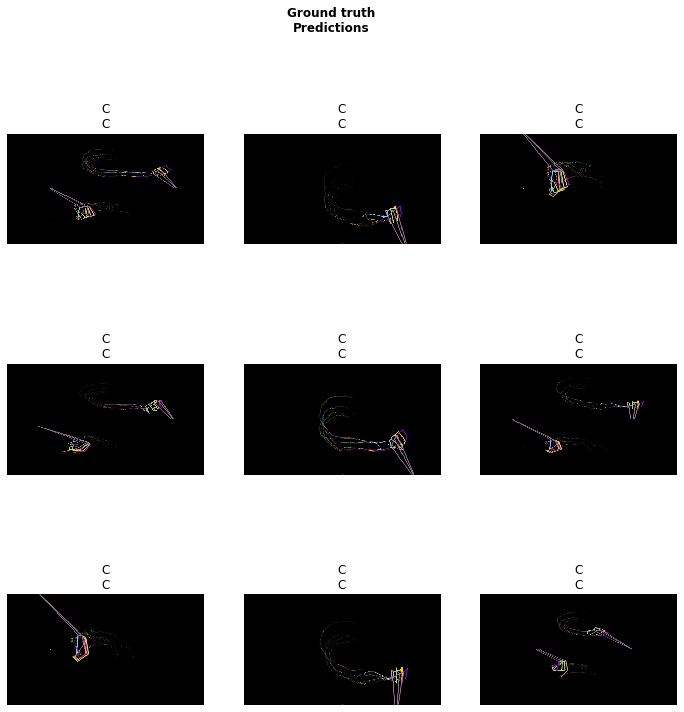

In [54]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

## Round 3 - 576x324px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


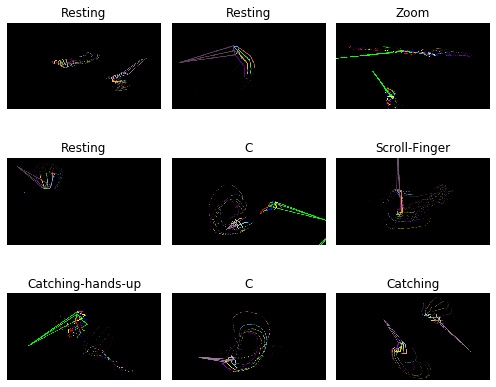

In [55]:
bs=64
img_size=[int(x/10*3) for x in default_size] # 576x324
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([64, 3, 324, 576])
Image  shape: torch.Size([3, 324, 576])
Labels shape: torch.Size([64])
Label[0]: 0 -> C
Label[2]: 0


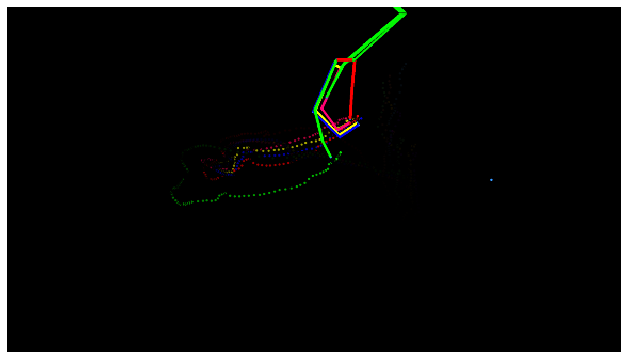

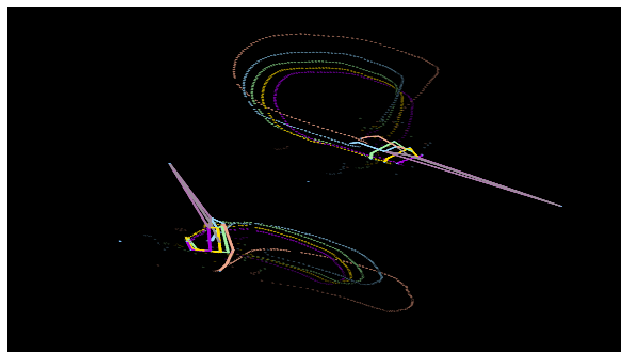

In [56]:
show_augmented_images()

In [57]:
show_hyperparams()

Batch size: 64, image size: [324, 576], learning rate: 0.0001


In [58]:
train_round=3
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


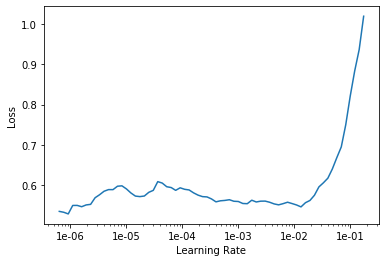

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr=1e-2

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[324, 576]-3a-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [25768, 24769]


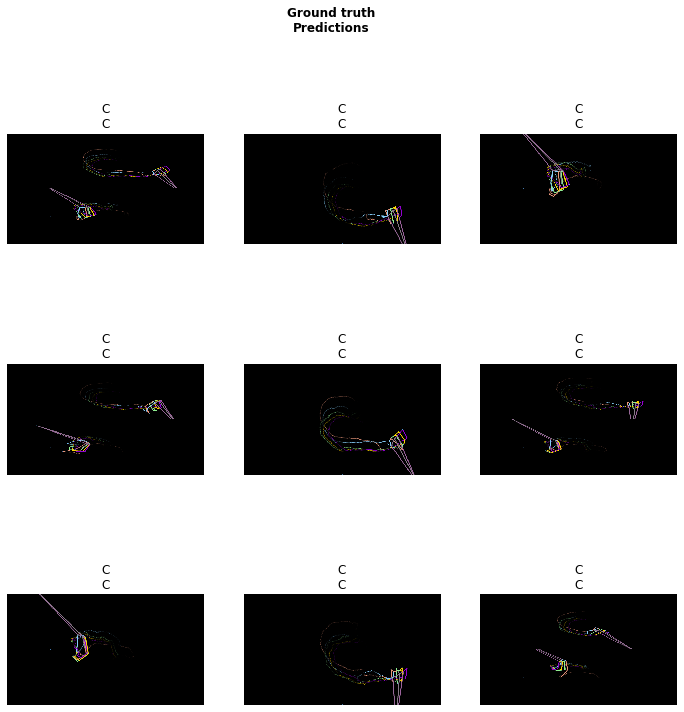

In [61]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [62]:
train_round=3
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


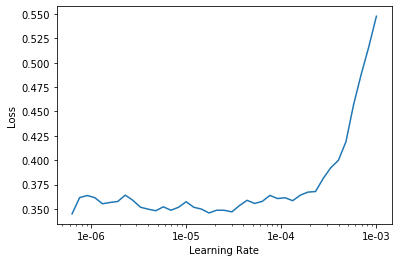

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
lr=1e-4

In [65]:
show_hyperparams()

Batch size: 64, image size: [324, 576], learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[324, 576]-3b-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [25856, 1087]


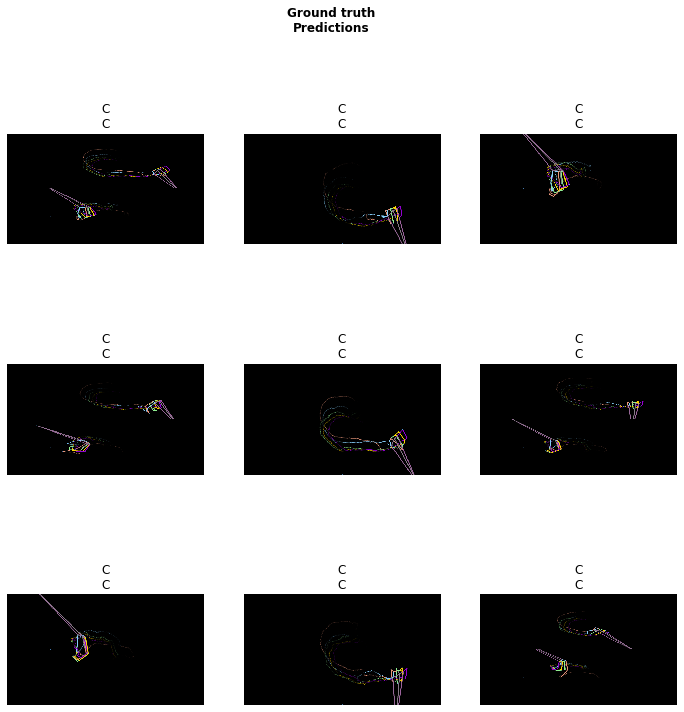

In [66]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

## Round 4 - 960x540px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


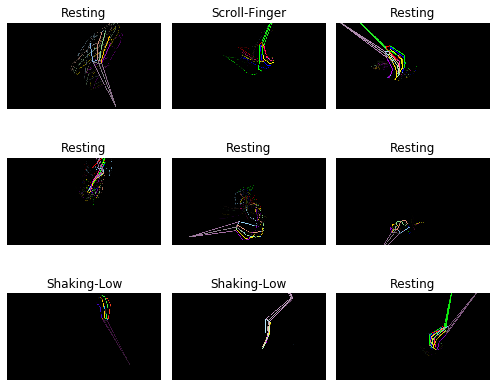

In [67]:
bs=16
img_size=[int(x/2) for x in default_size] # 960x540
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([16, 3, 540, 960])
Image  shape: torch.Size([3, 540, 960])
Labels shape: torch.Size([16])
Label[0]: 11 -> Shaking-Raised-Fist
Label[2]: 11


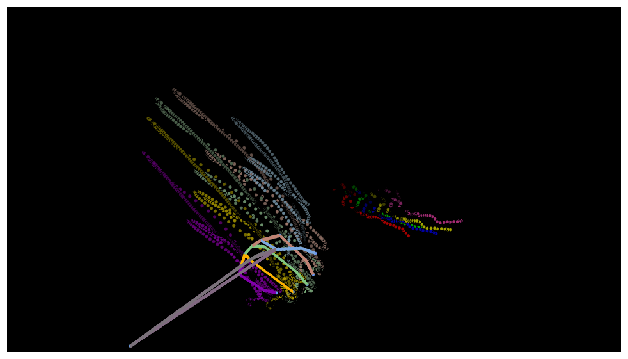

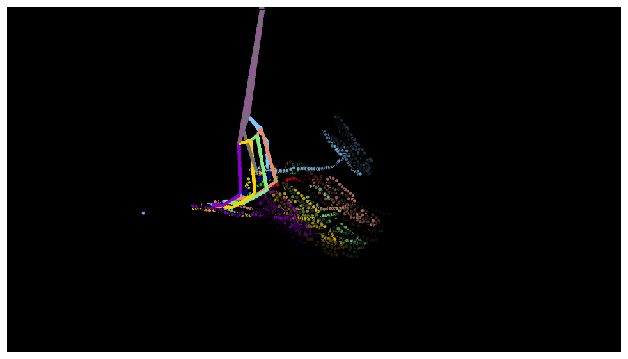

In [68]:
show_augmented_images()

In [69]:
show_hyperparams()

Batch size: 16, image size: [540, 960], learning rate: 0.0001


In [70]:
train_round=4
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


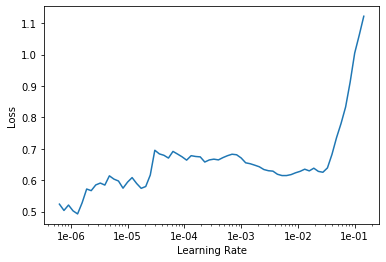

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
lr=1e-2

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[540, 960]-4a-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [18118, 17031]


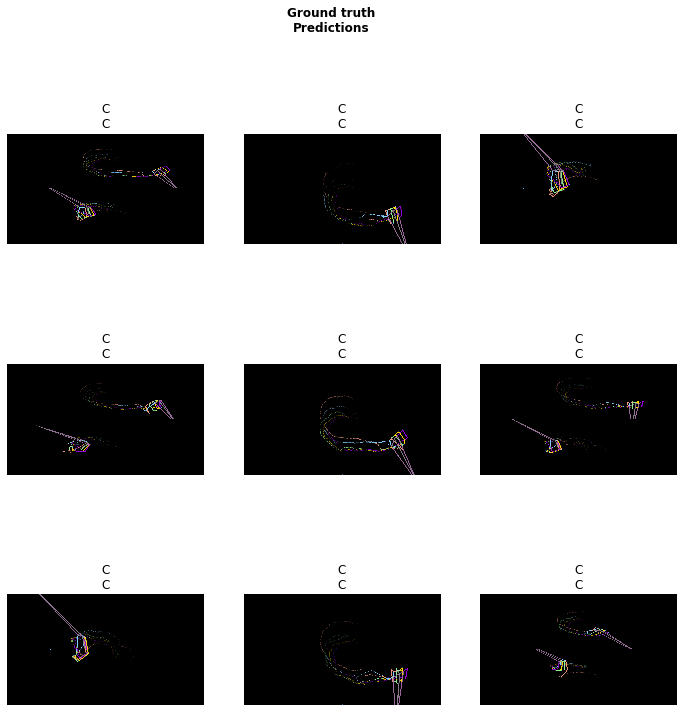

In [73]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [74]:
train_round=4
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


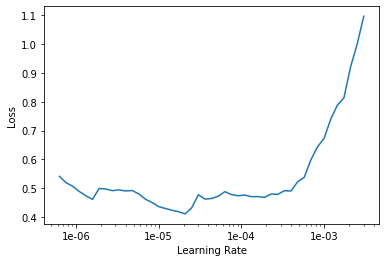

In [75]:
learn.lr_find()
learn.recorder.plot()

In [76]:
lr=1e-4

In [77]:
show_hyperparams()

Batch size: 16, image size: [540, 960], learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[540, 960]-4b-2020-02-20_16.36.47


nvidia-smi memory usage/increment: [18216, 1185]


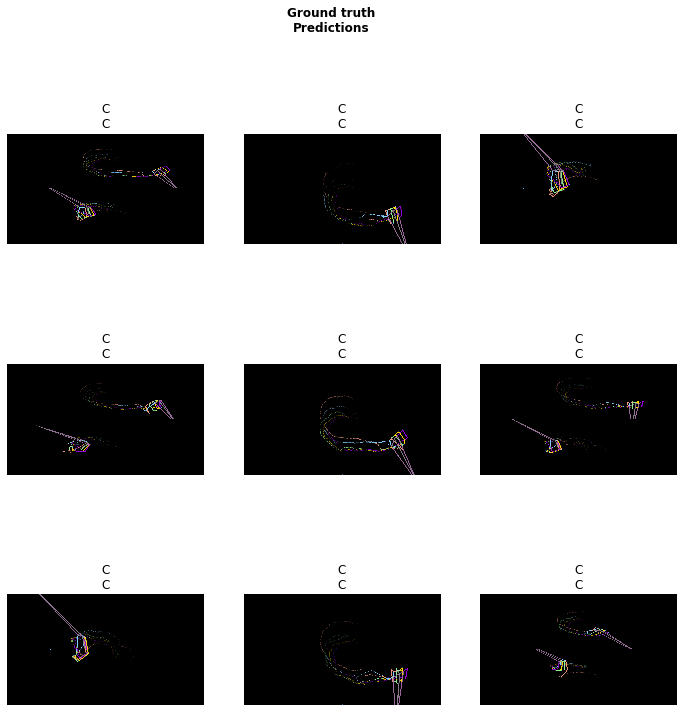

In [78]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

## Round 5 - 1536x864px

#### Reload the best model for the last image size because of a CUDA OOM (and then the model also went totally nuts)

In [31]:
# resnet-50-img_size-[540, 960]-4b-2020-02-20_16.36.47_8.pth
load_img_size = '[540, 960]'
load_name     = '4b'
load_currtime = '2020-02-20_16.36.47'
load_epoch    = 8
model_name_to_load = str(savepath) + '/' + model_name + '-img_size-' + str(load_img_size) + '-' + load_name + '-' + load_currtime + '_' + str(load_epoch)
print(f'Loading: {model_name_to_load}')

learn.load(model_name_to_load)
learn.path = savepath # don't forget this if you want to be able to conclude an epoch with data from a read-only directory!
learn.data = data     # this one is necessary...
print(f'Save path: {savepath}')

Loading: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[540, 960]-4b-2020-02-20_16.36.47_8
Save path: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models


The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


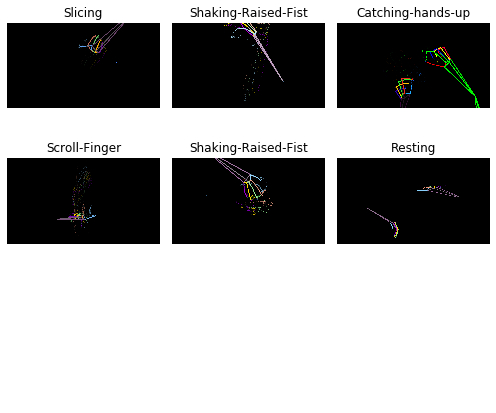

In [32]:
bs=6
img_size=[int(x/10*8) for x in default_size] # 1536x864
data = create_dataset(bs, img_size)
learn.data = data

In [33]:
train_round=5
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Batch  shape: torch.Size([6, 3, 864, 1536])
Image  shape: torch.Size([3, 864, 1536])
Labels shape: torch.Size([6])
Label[0]: 6 -> Resting
Label[2]: 6


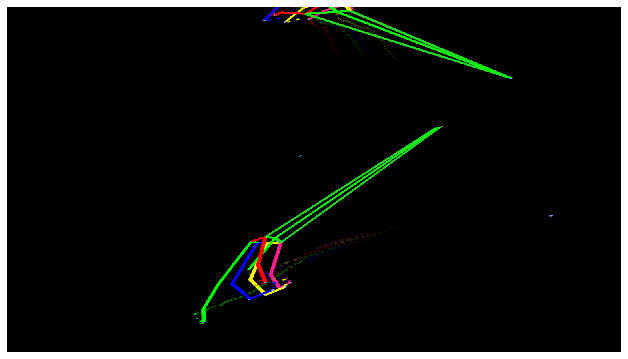

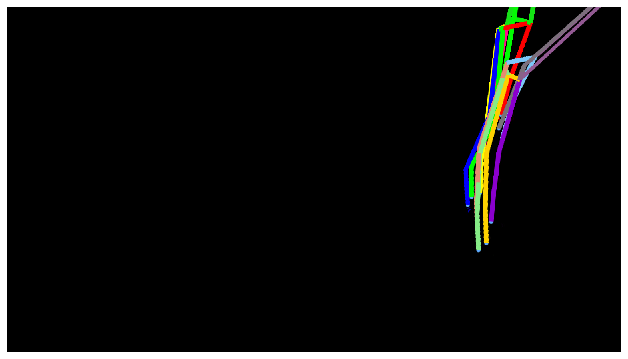

In [34]:
show_augmented_images()

In [35]:
show_hyperparams()

Batch size: 6, image size: [864, 1536], learning rate: 0.01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


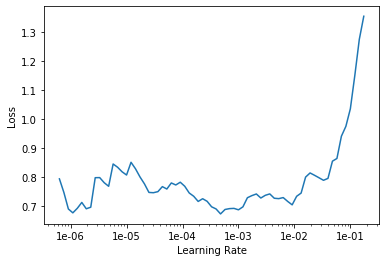

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
lr=1e-3

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-864-1536-5a-2020-02-21_12.20.09


nvidia-smi memory usage/increment: [17508, 17136]


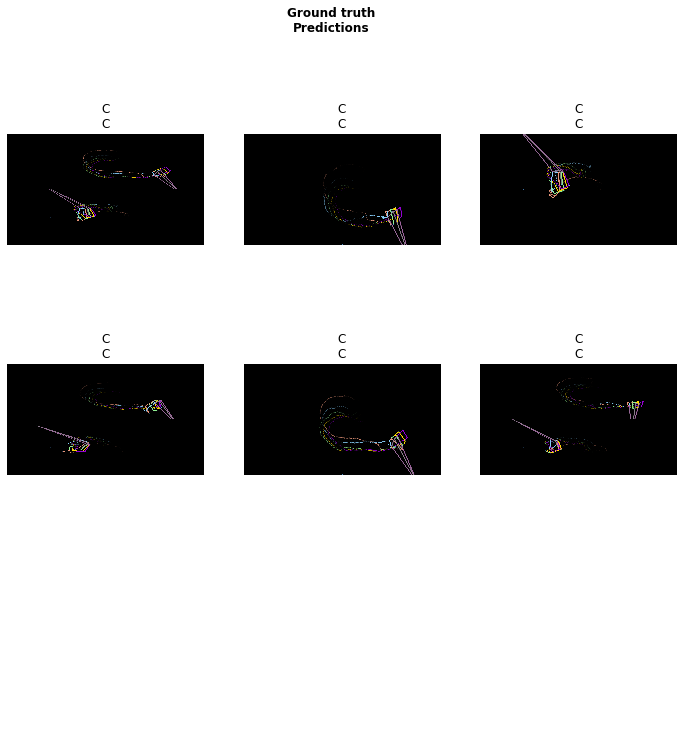

In [38]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [39]:
train_round=5
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


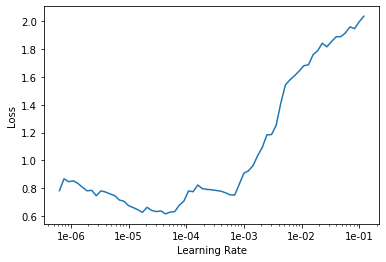

In [40]:
learn.lr_find()
learn.recorder.plot()

In [44]:
lr=1e-5

In [45]:
show_hyperparams()

Batch size: 6, image size: [864, 1536], learning rate: 1e-05


Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-864-1536-5b-2020-02-21_12.20.09


nvidia-smi memory usage/increment: [19175, 2039]


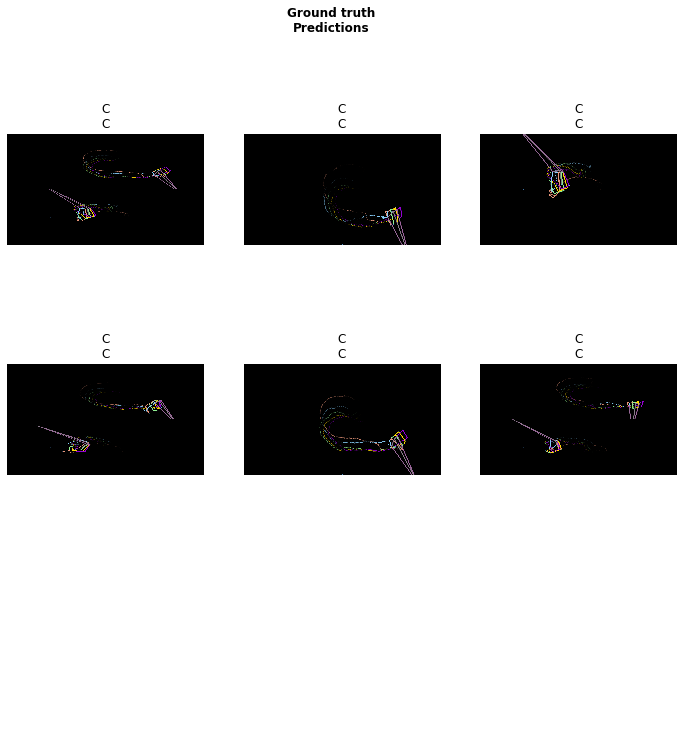

In [46]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-864-1536-5b-lower-lr-2020-02-21_12.20.09


nvidia-smi memory usage/increment: [19183, 17144]


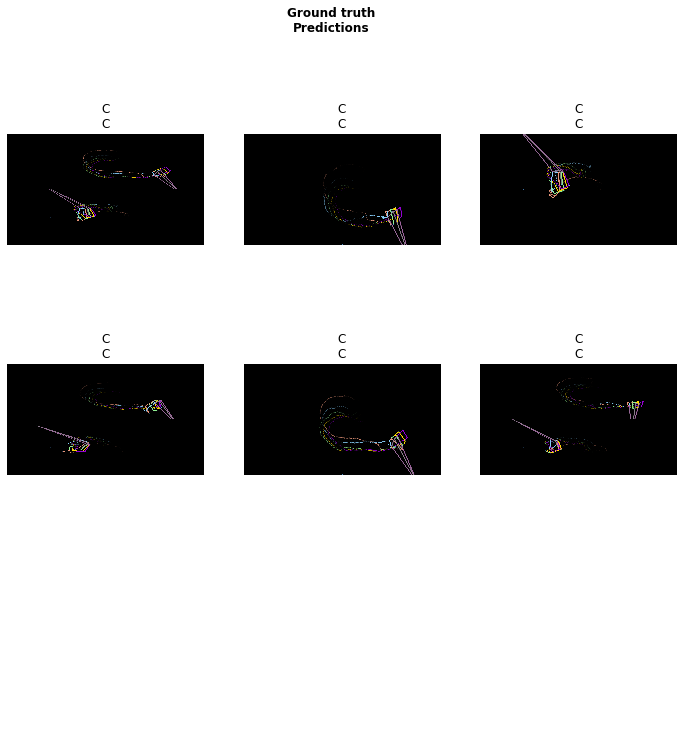

In [47]:
do_fit_fc(str(train_round) + model_frozen_letter + '-lower-lr', epochs=10, lr=lr/100)

Interpreting results and plotting top losses for stage-5


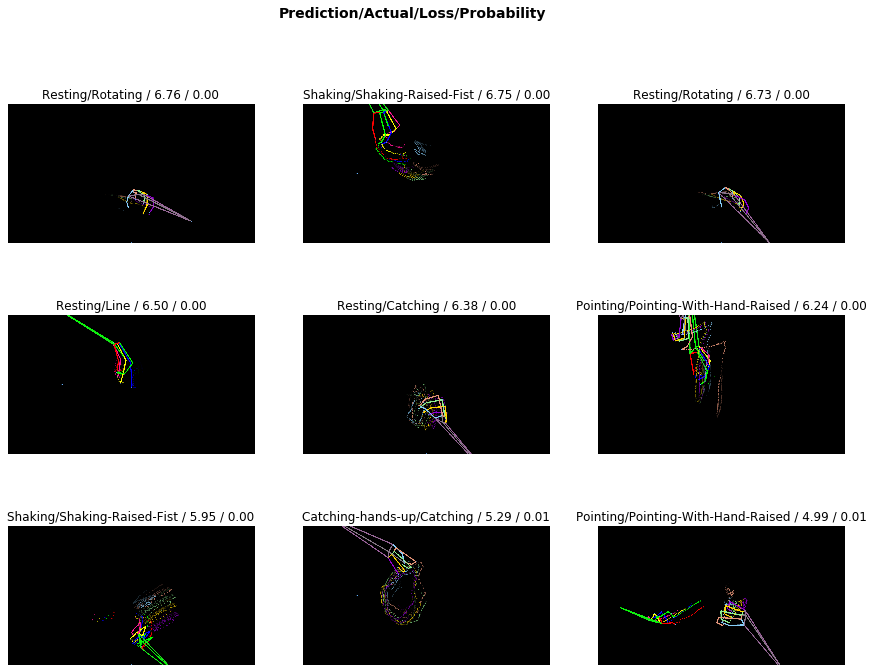

In [48]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-5


[('Pointing-With-Hand-Raised', 'Pointing', 21),
 ('Resting', 'C', 16),
 ('Catching-hands-up', 'Catching', 10),
 ('Shaking-Raised-Fist', 'Shaking-Low', 10),
 ('Resting', 'Pointing', 7),
 ('Rotating', 'Resting', 7),
 ('Zoom', 'Resting', 7),
 ('Resting', 'Scroll-Finger', 6),
 ('Shaking-Raised-Fist', 'Shaking', 6),
 ('Pointing', 'Resting', 5),
 ('Line', 'Resting', 4),
 ('Catching', 'Catching-hands-up', 3),
 ('Line', 'Pointing', 3),
 ('Resting', 'Shaking-Low', 3),
 ('Resting', 'Shaking-Raised-Fist', 3),
 ('Shaking-Raised-Fist', 'Resting', 3),
 ('Pointing', 'Pointing-With-Hand-Raised', 2),
 ('Resting', 'Slicing', 2),
 ('Zoom', 'Line', 2)]

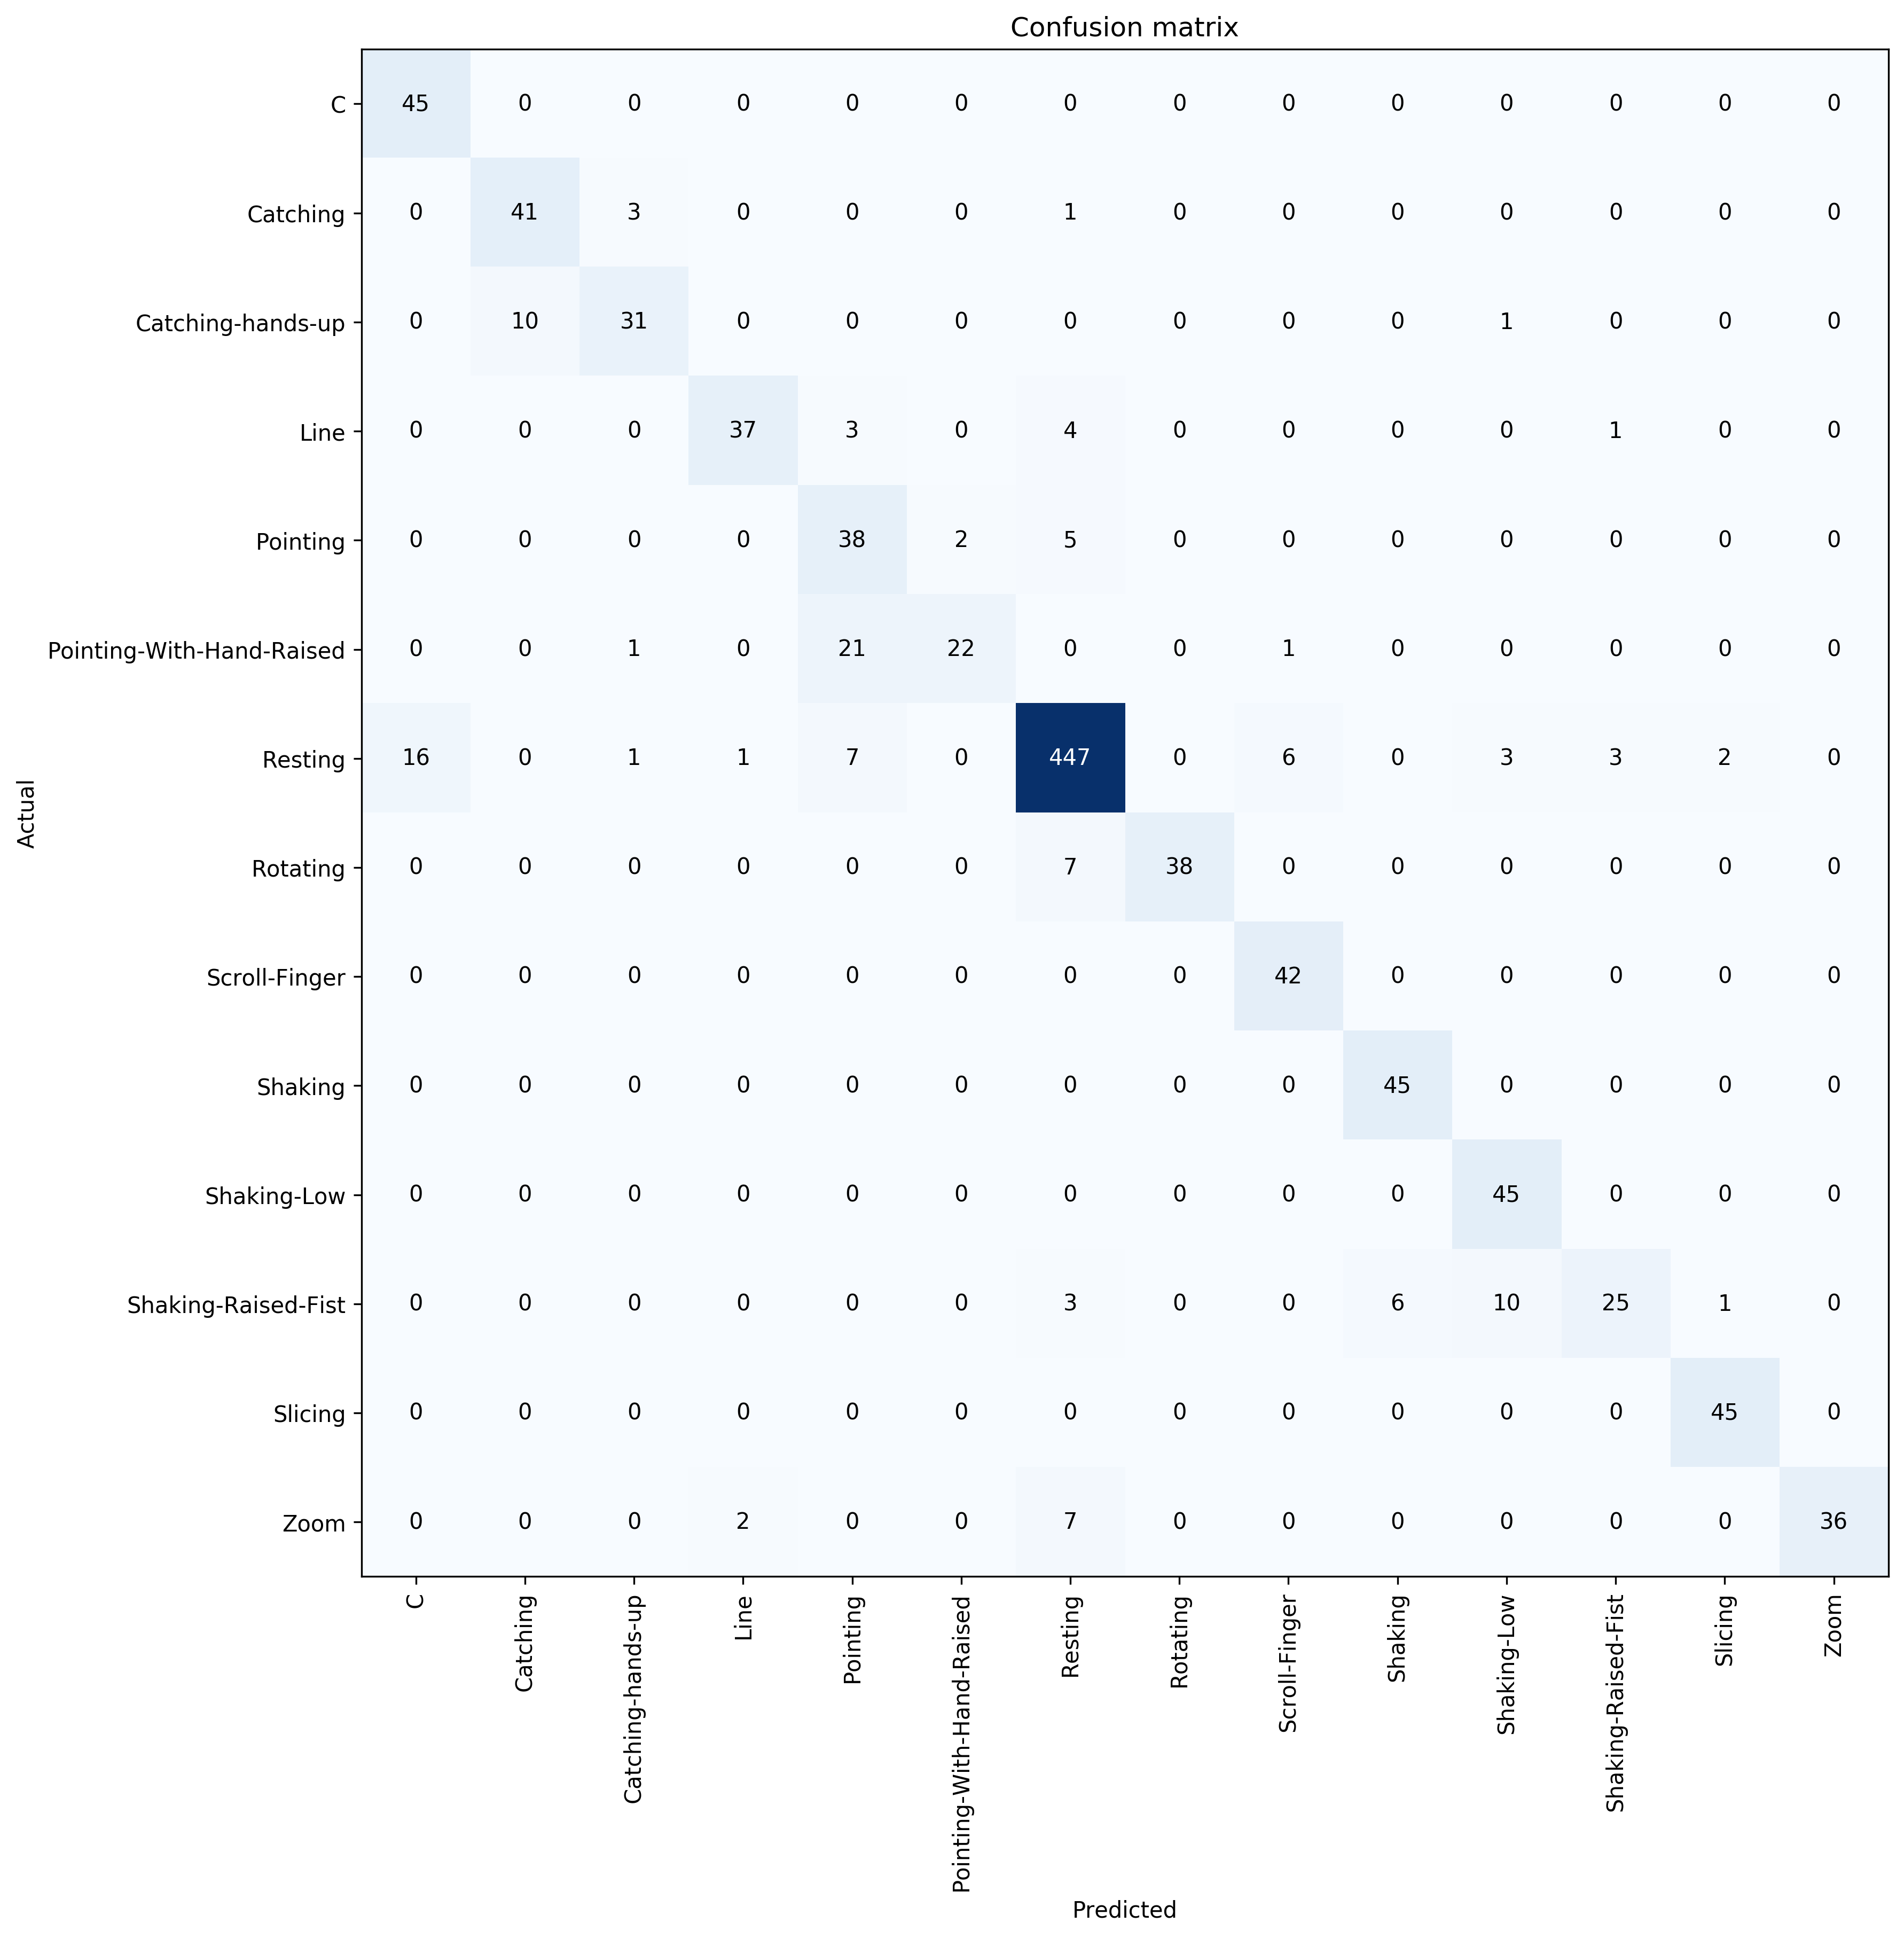

In [49]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-5


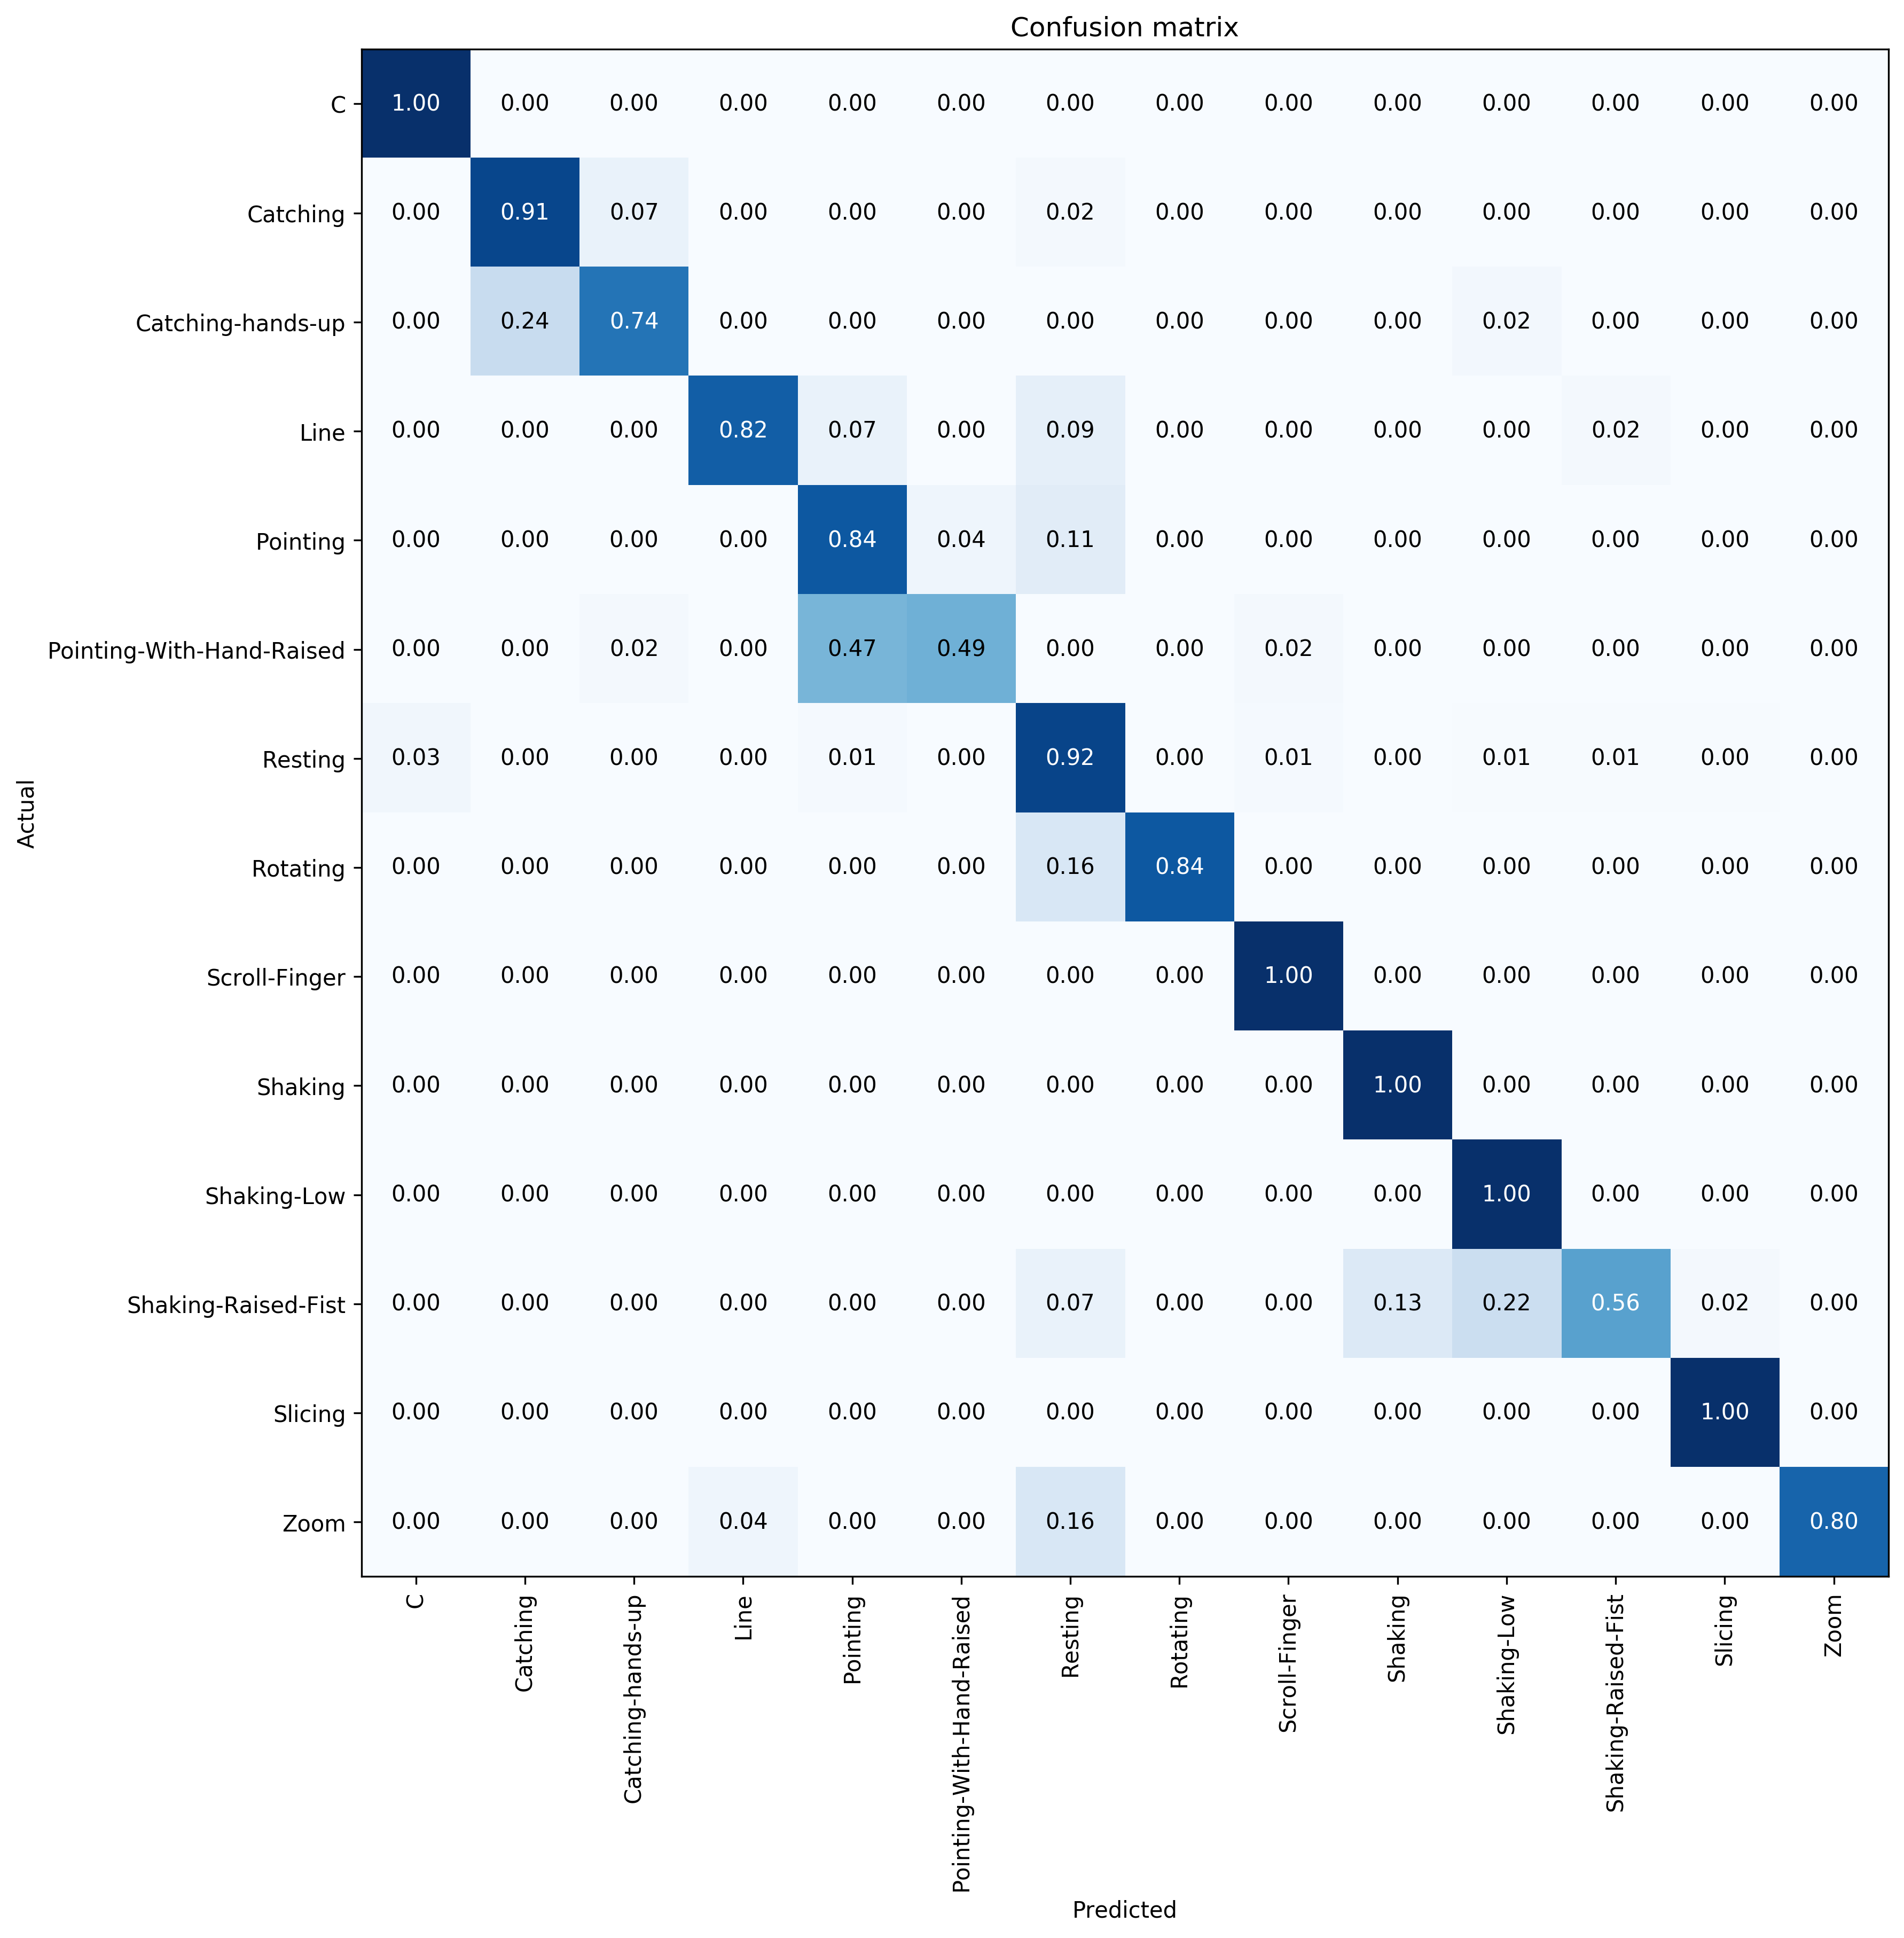

In [50]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

## Round 6 - 1920x1080px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


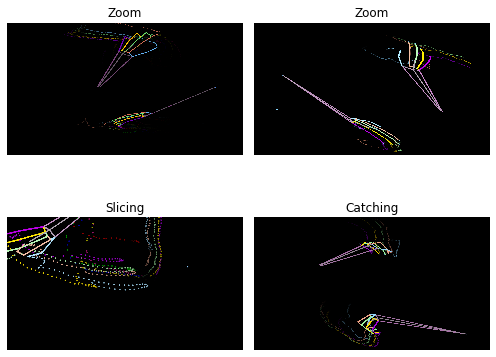

In [51]:
bs=4
img_size=default_size # leave the default 1920x1080 16:9 rectangular aspect ratio
data = create_dataset(bs, img_size)
learn.data = data

In [52]:
train_round=6
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Batch  shape: torch.Size([4, 3, 1080, 1920])
Image  shape: torch.Size([3, 1080, 1920])
Labels shape: torch.Size([4])
Label[0]: 6 -> Resting
Label[2]: 7


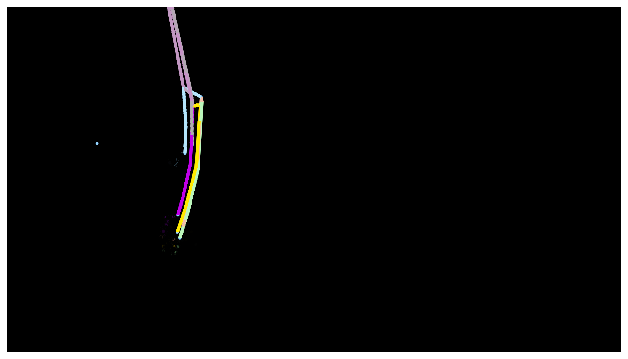

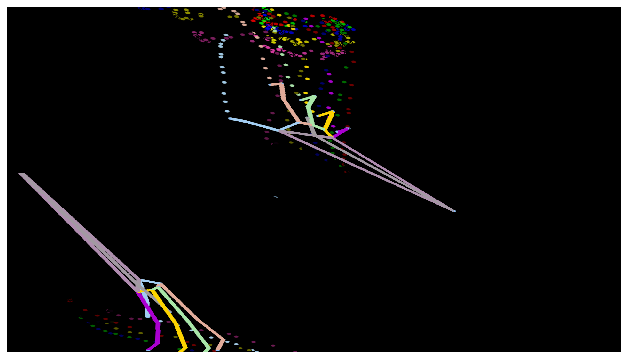

In [53]:
show_augmented_images()

In [54]:
show_hyperparams()

Batch size: 4, image size: (1080, 1920), learning rate: 1e-05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


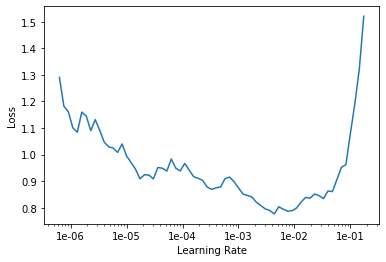

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
lr=1e-3

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-1080-1920-6a-2020-02-21_12.20.09


nvidia-smi memory usage/increment: [19877, 2733]


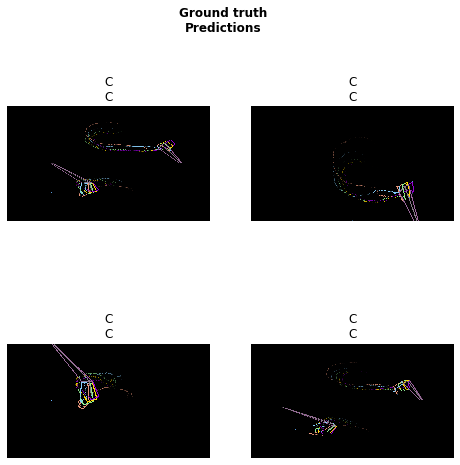

In [57]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [58]:
train_round=6
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


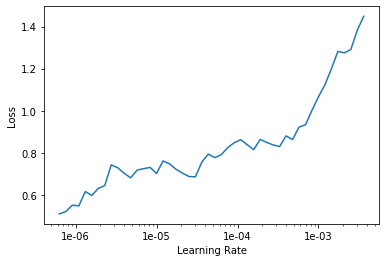

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr=1e-6

In [61]:
show_hyperparams()

Batch size: 4, image size: (1080, 1920), learning rate: 1e-06


Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-1080-1920-6b-2020-02-21_12.20.09


nvidia-smi memory usage/increment: [20651, 17918]


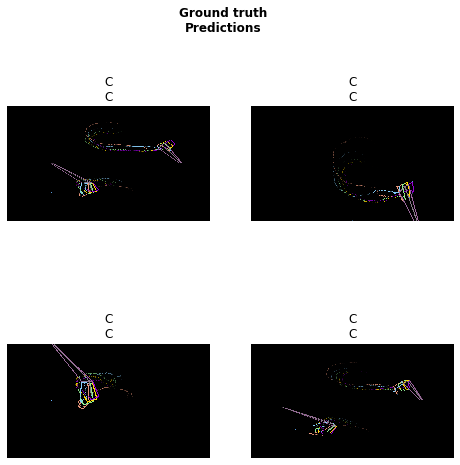

In [62]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Learner object has path in: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-1080-1920-6b-lower-lr-2020-02-21_12.20.09


nvidia-smi memory usage/increment: [20651, 2733]


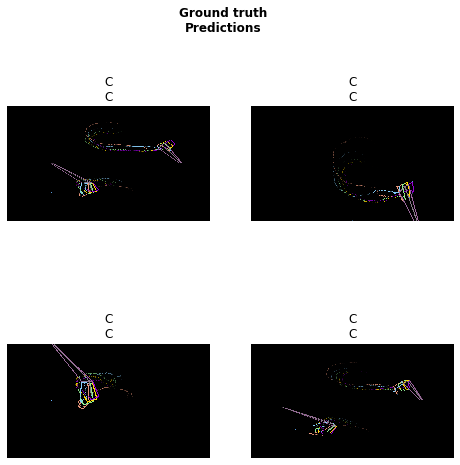

In [63]:
do_fit_fc(str(train_round) + model_frozen_letter + '-lower-lr', epochs=10, lr=lr/10)

Interpreting results and plotting top losses for stage-6


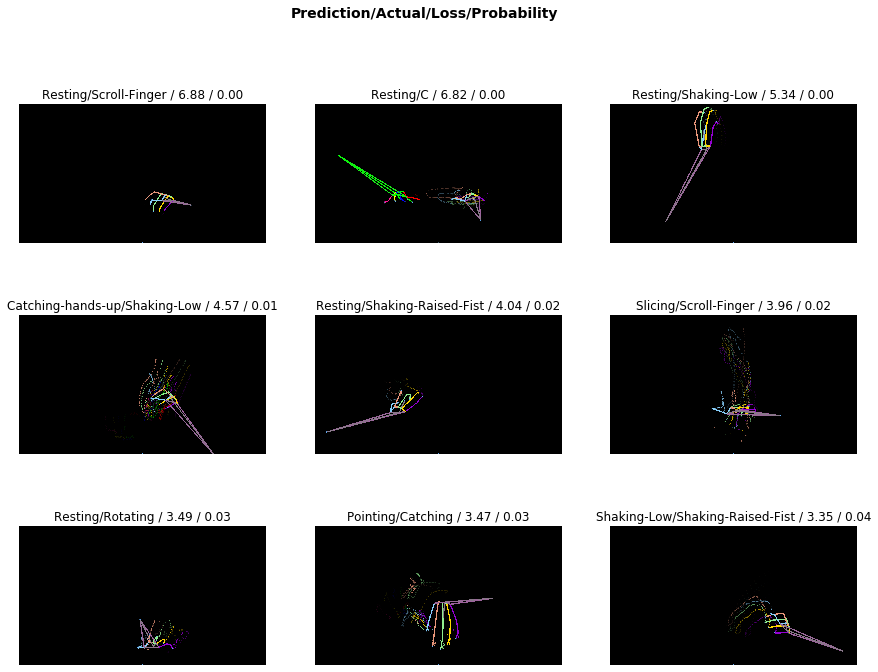

In [105]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-6


[('Resting', 'Pointing', 6),
 ('Pointing-With-Hand-Raised', 'Pointing', 4),
 ('Rotating', 'Resting', 4),
 ('Pointing', 'Resting', 3),
 ('Resting', 'Scroll-Finger', 2),
 ('Resting', 'Slicing', 2)]

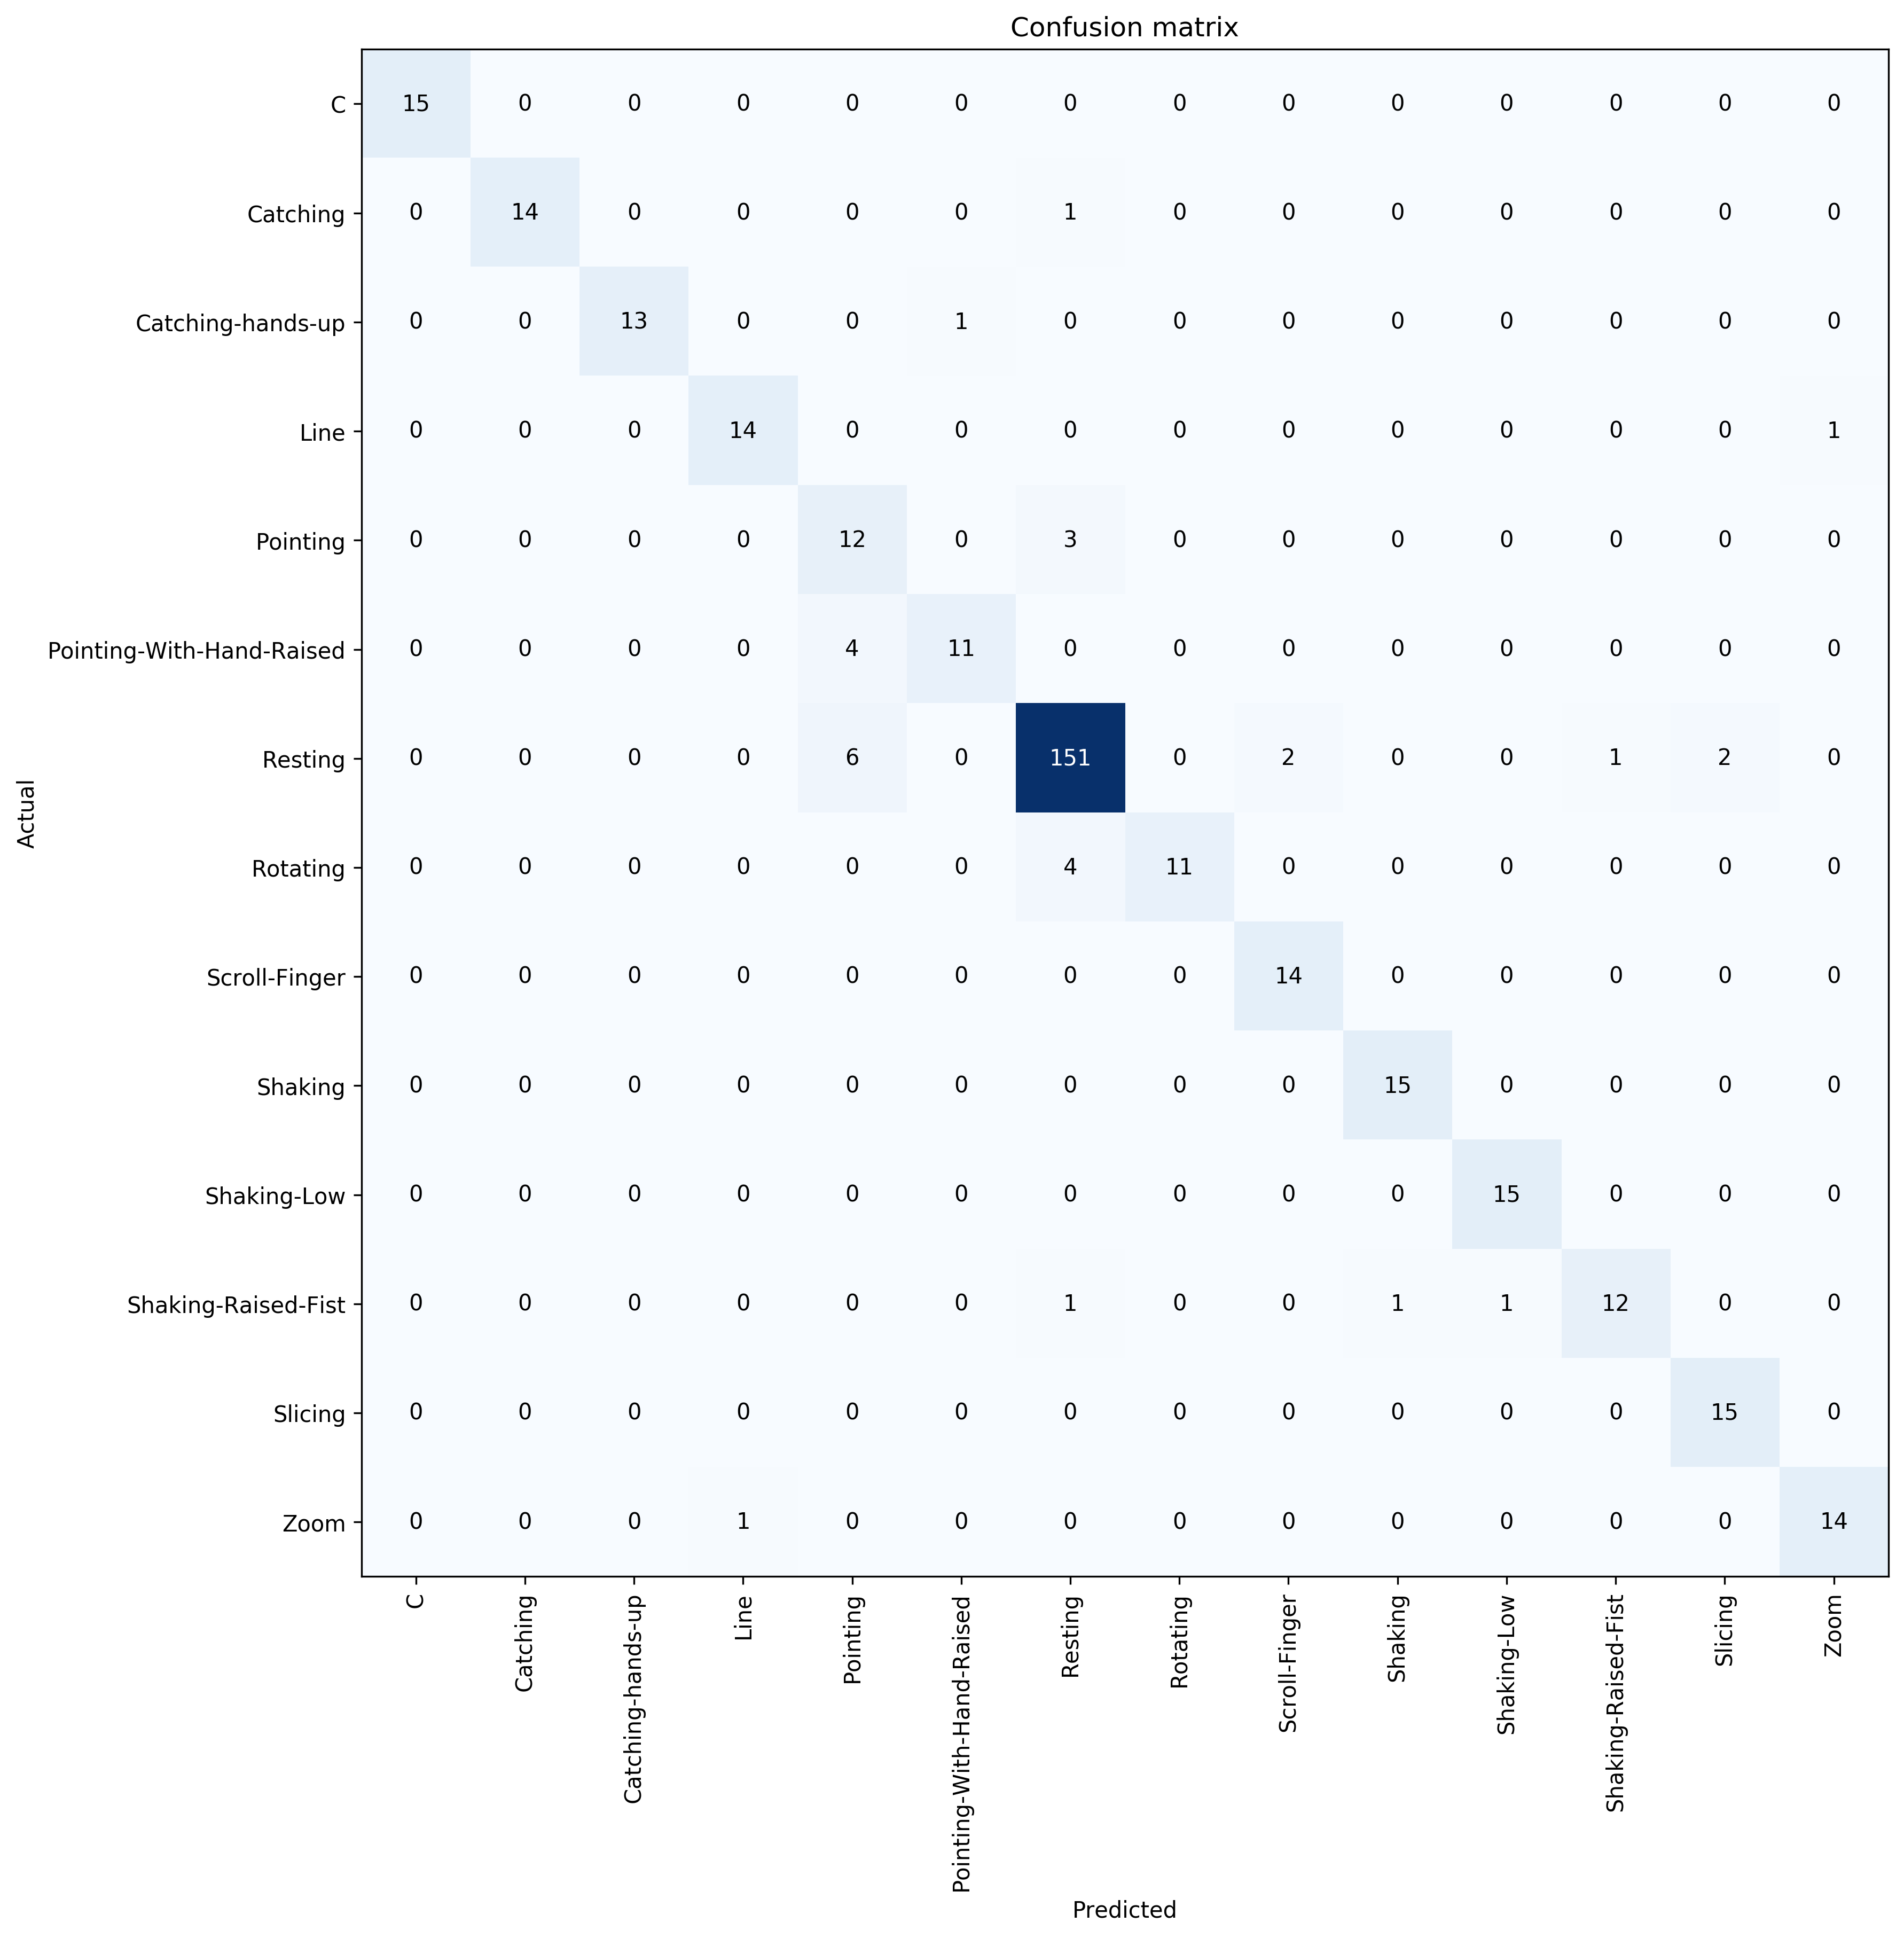

In [108]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-6


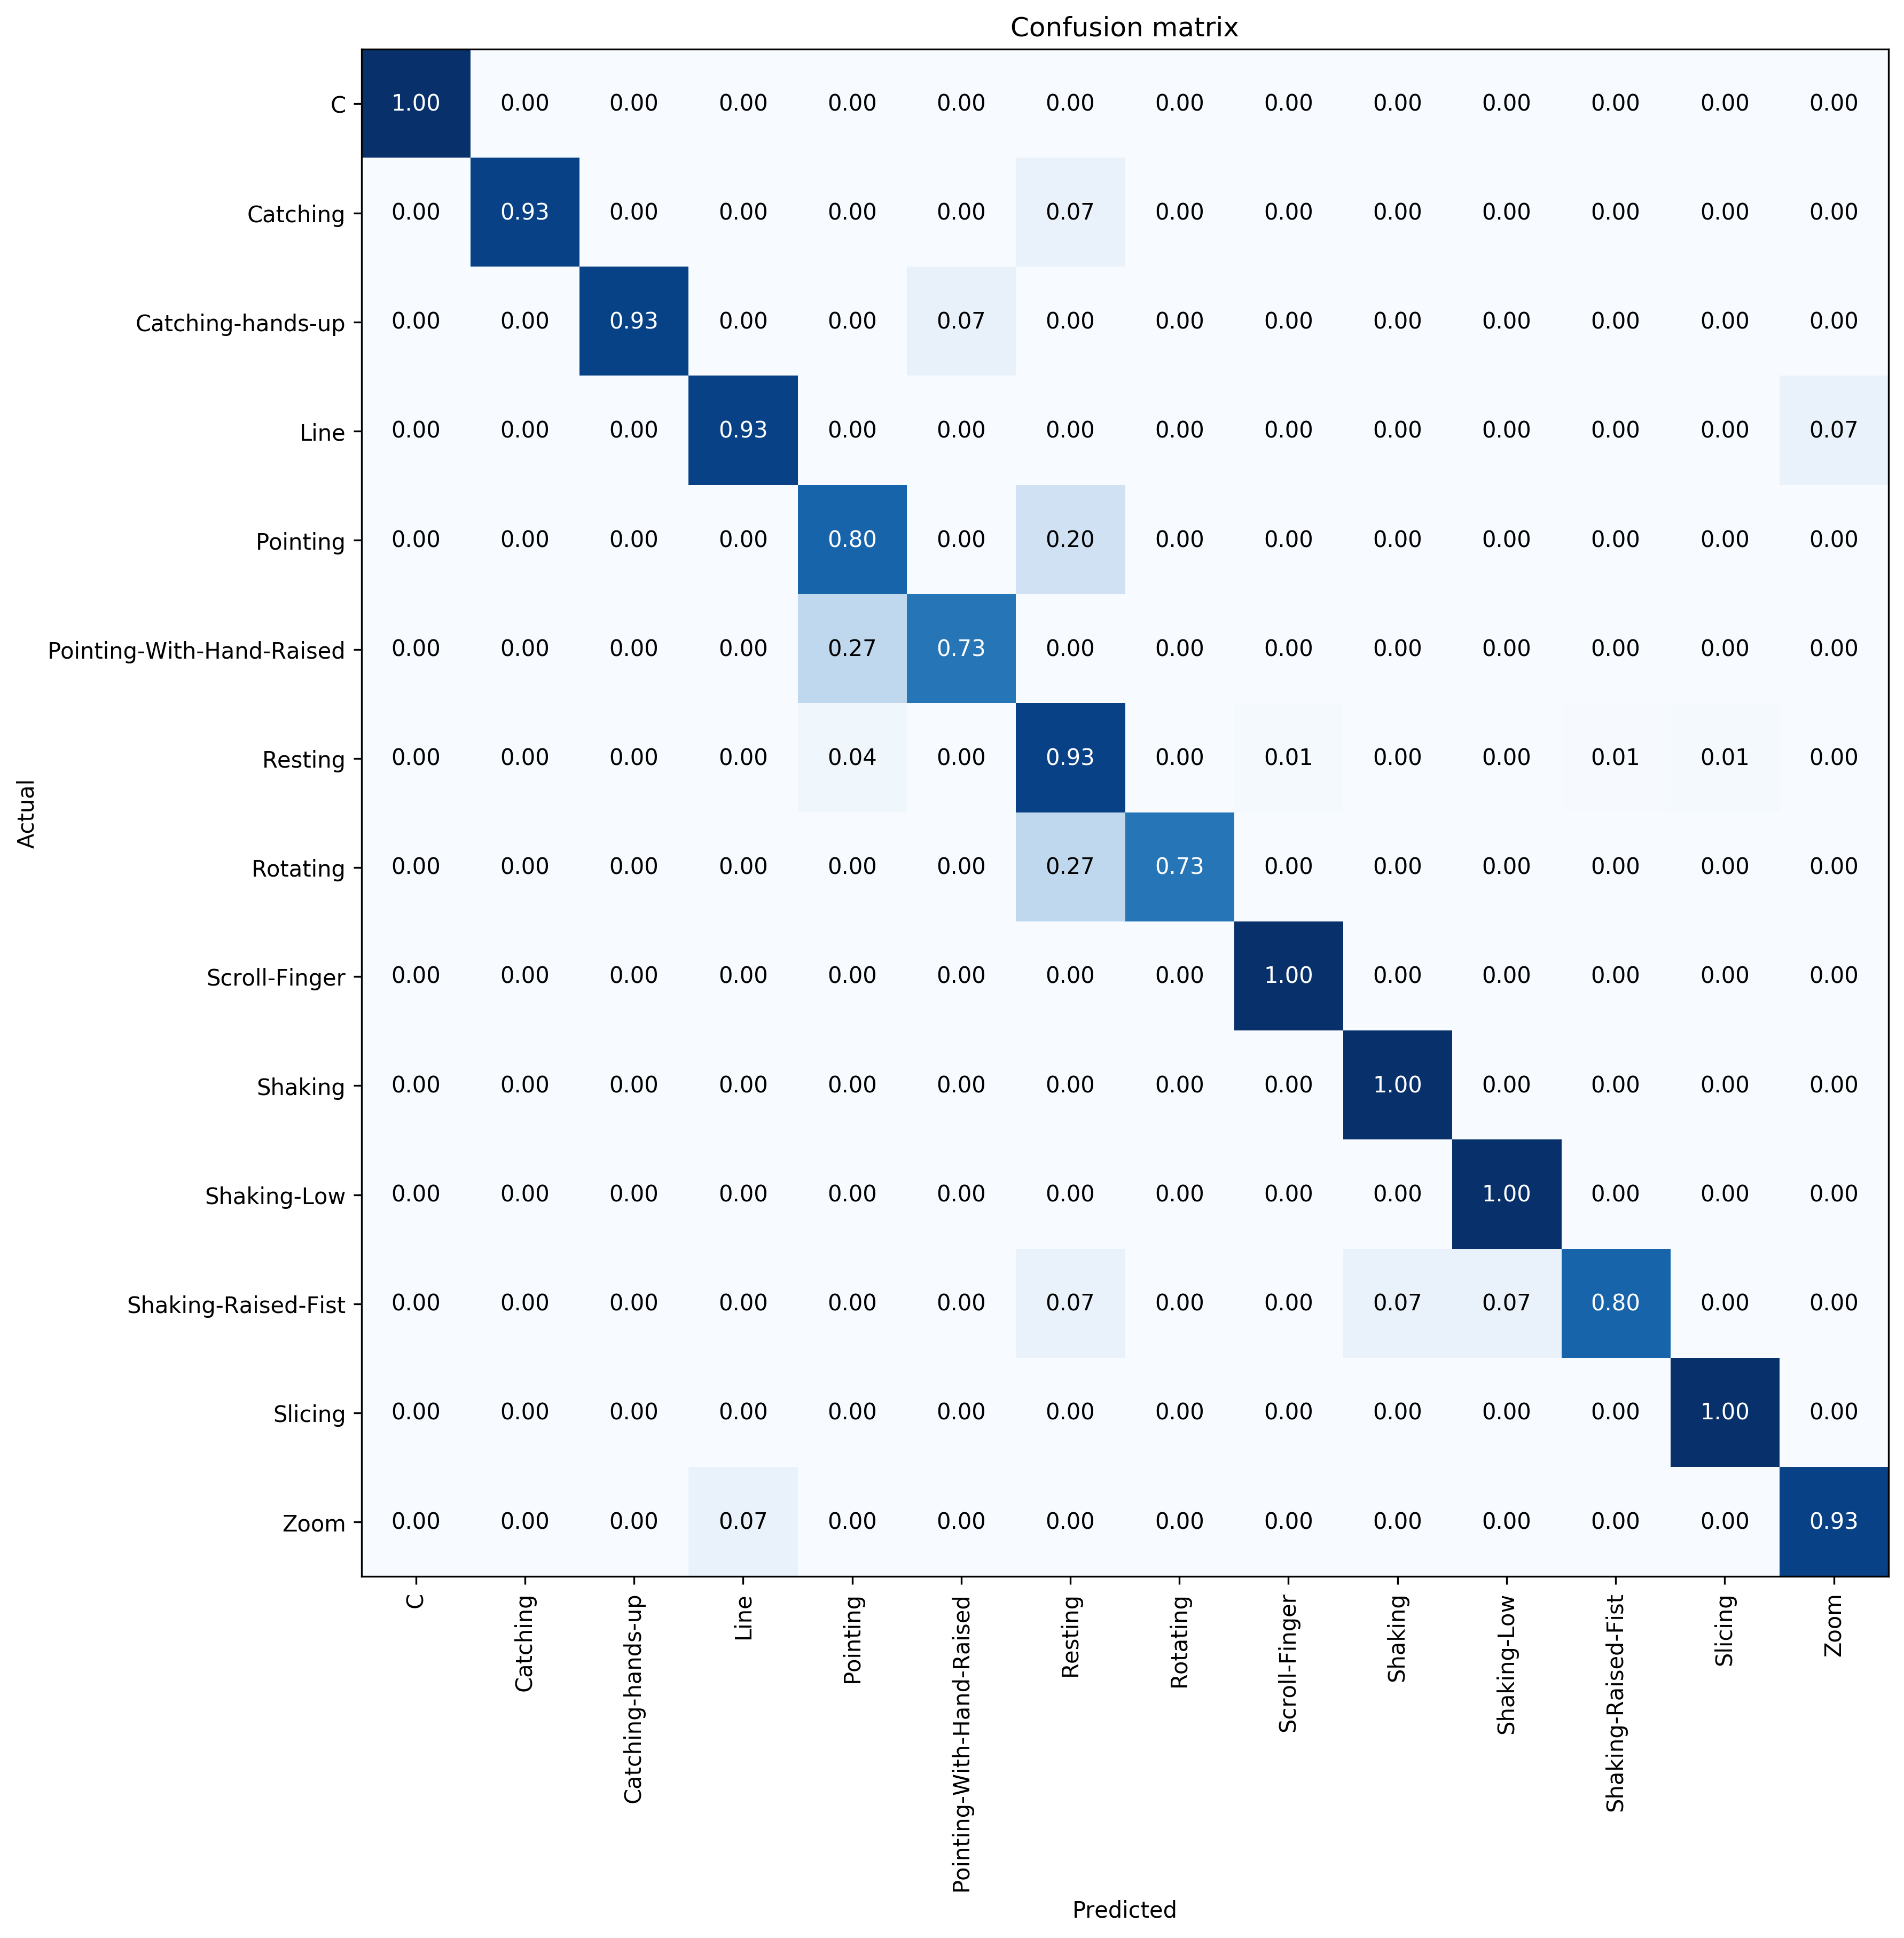

In [109]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [107]:
acc = evaluate_model_from_interp(interp, data)

Interp has 339 ground truth labels: tensor([ 1,  7,  6,  7,  4,  6, 10, 13,  5,  8,  6,  1,  9,  6,  6, 11, 12,  7,
         5,  0,  7,  0,  7,  6,  7,  2,  1,  6,  7,  6,  6,  6,  3,  6,  6,  3,
         6,  6,  7,  6,  6,  6,  6,  6,  4,  9,  6,  6,  7,  6, 10,  6,  1,  6,
         6,  1, 12,  6,  6,  2,  0,  8,  3,  6,  6,  6,  6,  2,  3,  6,  6, 10,
         2,  1,  7, 13,  6,  6, 13,  6,  6,  3,  6,  6,  3,  6,  6,  9,  0,  6,
         4,  6, 13,  6, 11, 13,  6,  3, 11,  2,  7,  6,  6,  6,  6, 12,  6,  7,
         6,  6,  9,  6,  8,  4,  6,  6,  6,  3,  1,  6,  1,  3,  2,  0,  1,  9,
         6, 10,  7, 12, 11,  6, 13,  6,  6,  6,  9,  6,  5, 11,  3,  3, 13,  4,
        12,  6,  4,  1,  6,  6,  5,  6,  6,  6,  0,  6,  3,  7, 11,  8,  6, 11,
         6,  3,  6, 11,  1,  6,  9,  9,  8, 12,  4,  1, 11,  6,  6,  7, 12,  7,
         6,  6,  2, 12,  1, 10,  0,  6,  6,  3,  2,  6,  6,  8,  0, 10,  4, 13,
         6,  3,  6, 12,  6,  6,  1,  3,  9,  6,  8,  6,  6,  6, 13,  6, 11,  9,
    

# Reload the best model

### Best model is @ Round 3 - 576x324 - epoch 9 - 92.11% accuracy

In [64]:
# resnet-50-img_size-[324, 576]-3b-2020-02-20_16.36.47_9.pth
load_img_size = '[324, 576]'
load_name     = '3b'
load_currtime = '2020-02-20_16.36.47'
load_epoch    = 9
model_name_to_load = str(savepath) + '/' + model_name + '-img_size-' + str(load_img_size) + '-' + load_name + '-' + load_currtime + '_' + str(load_epoch)
print(f'Loading: {model_name_to_load}')

learn.load(model_name_to_load)
learn.path = savepath # don't forget this if you want to be able to conclude an epoch with data from a read-only directory!
learn.data = data     # this one is necessary...
print(f'Save path: {savepath}')

Loading: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-[324, 576]-3b-2020-02-20_16.36.47_9
Save path: /home/ranieri/dataset/dataset-dynamic-hand-gestures-top-right-and-double-view-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models


# Recreate the DataBunch as in Round 3 with the correct image size

### It's important to validate the model with the correct image size (576x324 in this case), otherwise accuracy will be certainly lower

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 2337, y: 2337)
Validation set len is: (x: 1065, y: 1065)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([2160, 1920]))


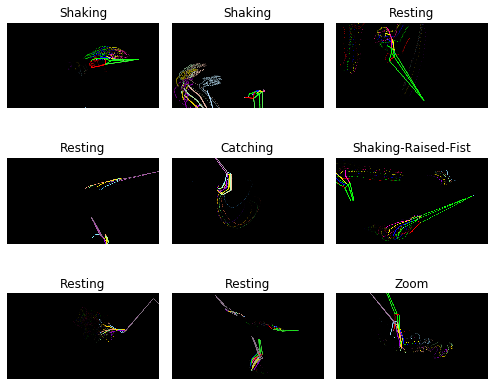

In [65]:
bs=64
img_size=[int(x/10*3) for x in default_size] # 576x324
data = create_dataset(bs, img_size)
learn.data = data

In [66]:
train_round = 3

# A little hack: change the labels to match the ones in the original paper

0. REST
1. POINT TO (POINTING)
2. CATCH
3. SHAKE WITH TWO HANDS (SHAKE FIST RAISED)
4. CATCH WITH TWO HANDS (CATCH HAND RAISED)
5. SHAKE DOWN (SHAKE LOW)
6. SHAKE
7. DRAW C
8. POINT TO WITH TWO HANDS (POINTER HAND RAISED)
9. ZOOM
10. SCROLL (SCROLL FINGER)
11. DRAW LINE (LINE)
12. SLICE
13. ROTATE

In [67]:
print(data.classes)
print(data.y.classes)

['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']


In [68]:
data.classes = [ 'Draw C', 'Catch', 'Catch With Two Hands', 'Draw Line', 'Point To', 'Point To With Two Hands', 'Rest', 'Rotate', 'Scroll', 'Shake', 'Shake Down', 'Shake With Two Hands', 'Slice', 'Zoom' ]
data.y.classes = data.classes
learn.data = data

In [69]:
print(learn.data.classes)
print(learn.data.y.classes)

['Draw C', 'Catch', 'Catch With Two Hands', 'Draw Line', 'Point To', 'Point To With Two Hands', 'Rest', 'Rotate', 'Scroll', 'Shake', 'Shake Down', 'Shake With Two Hands', 'Slice', 'Zoom']
['Draw C', 'Catch', 'Catch With Two Hands', 'Draw Line', 'Point To', 'Point To With Two Hands', 'Rest', 'Rotate', 'Scroll', 'Shake', 'Shake Down', 'Shake With Two Hands', 'Slice', 'Zoom']


Interpreting results and plotting top losses for stage-3


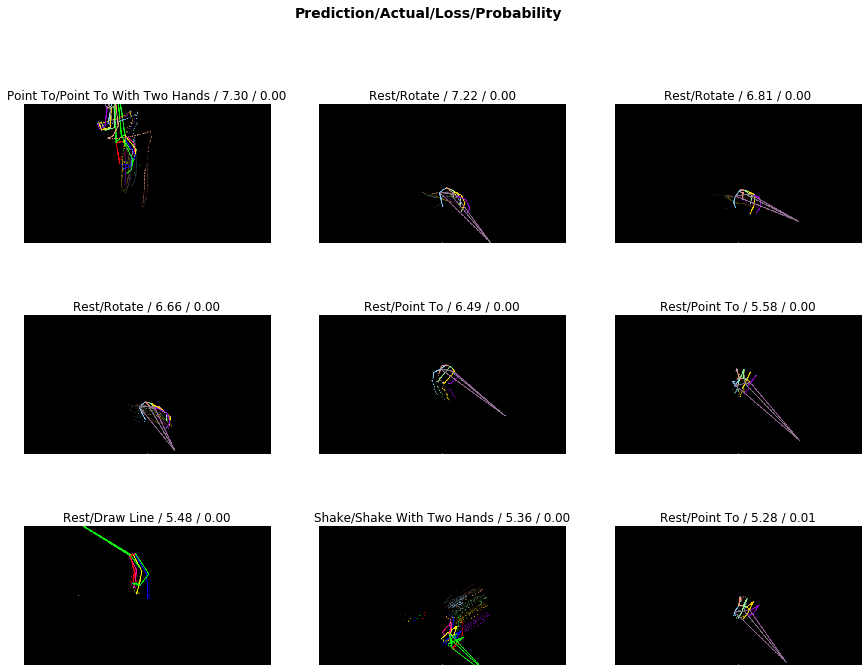

In [70]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-3


[('Rotate', 'Rest', 10),
 ('Point To With Two Hands', 'Point To', 9),
 ('Rest', 'Point To', 8),
 ('Point To', 'Rest', 7),
 ('Rest', 'Draw C', 7),
 ('Zoom', 'Rest', 5),
 ('Rest', 'Draw Line', 4),
 ('Shake With Two Hands', 'Shake Down', 4),
 ('Rest', 'Slice', 3),
 ('Shake With Two Hands', 'Shake', 3),
 ('Draw Line', 'Shake With Two Hands', 2),
 ('Rest', 'Scroll', 2),
 ('Rest', 'Shake With Two Hands', 2),
 ('Shake With Two Hands', 'Rest', 2),
 ('Shake With Two Hands', 'Zoom', 2)]

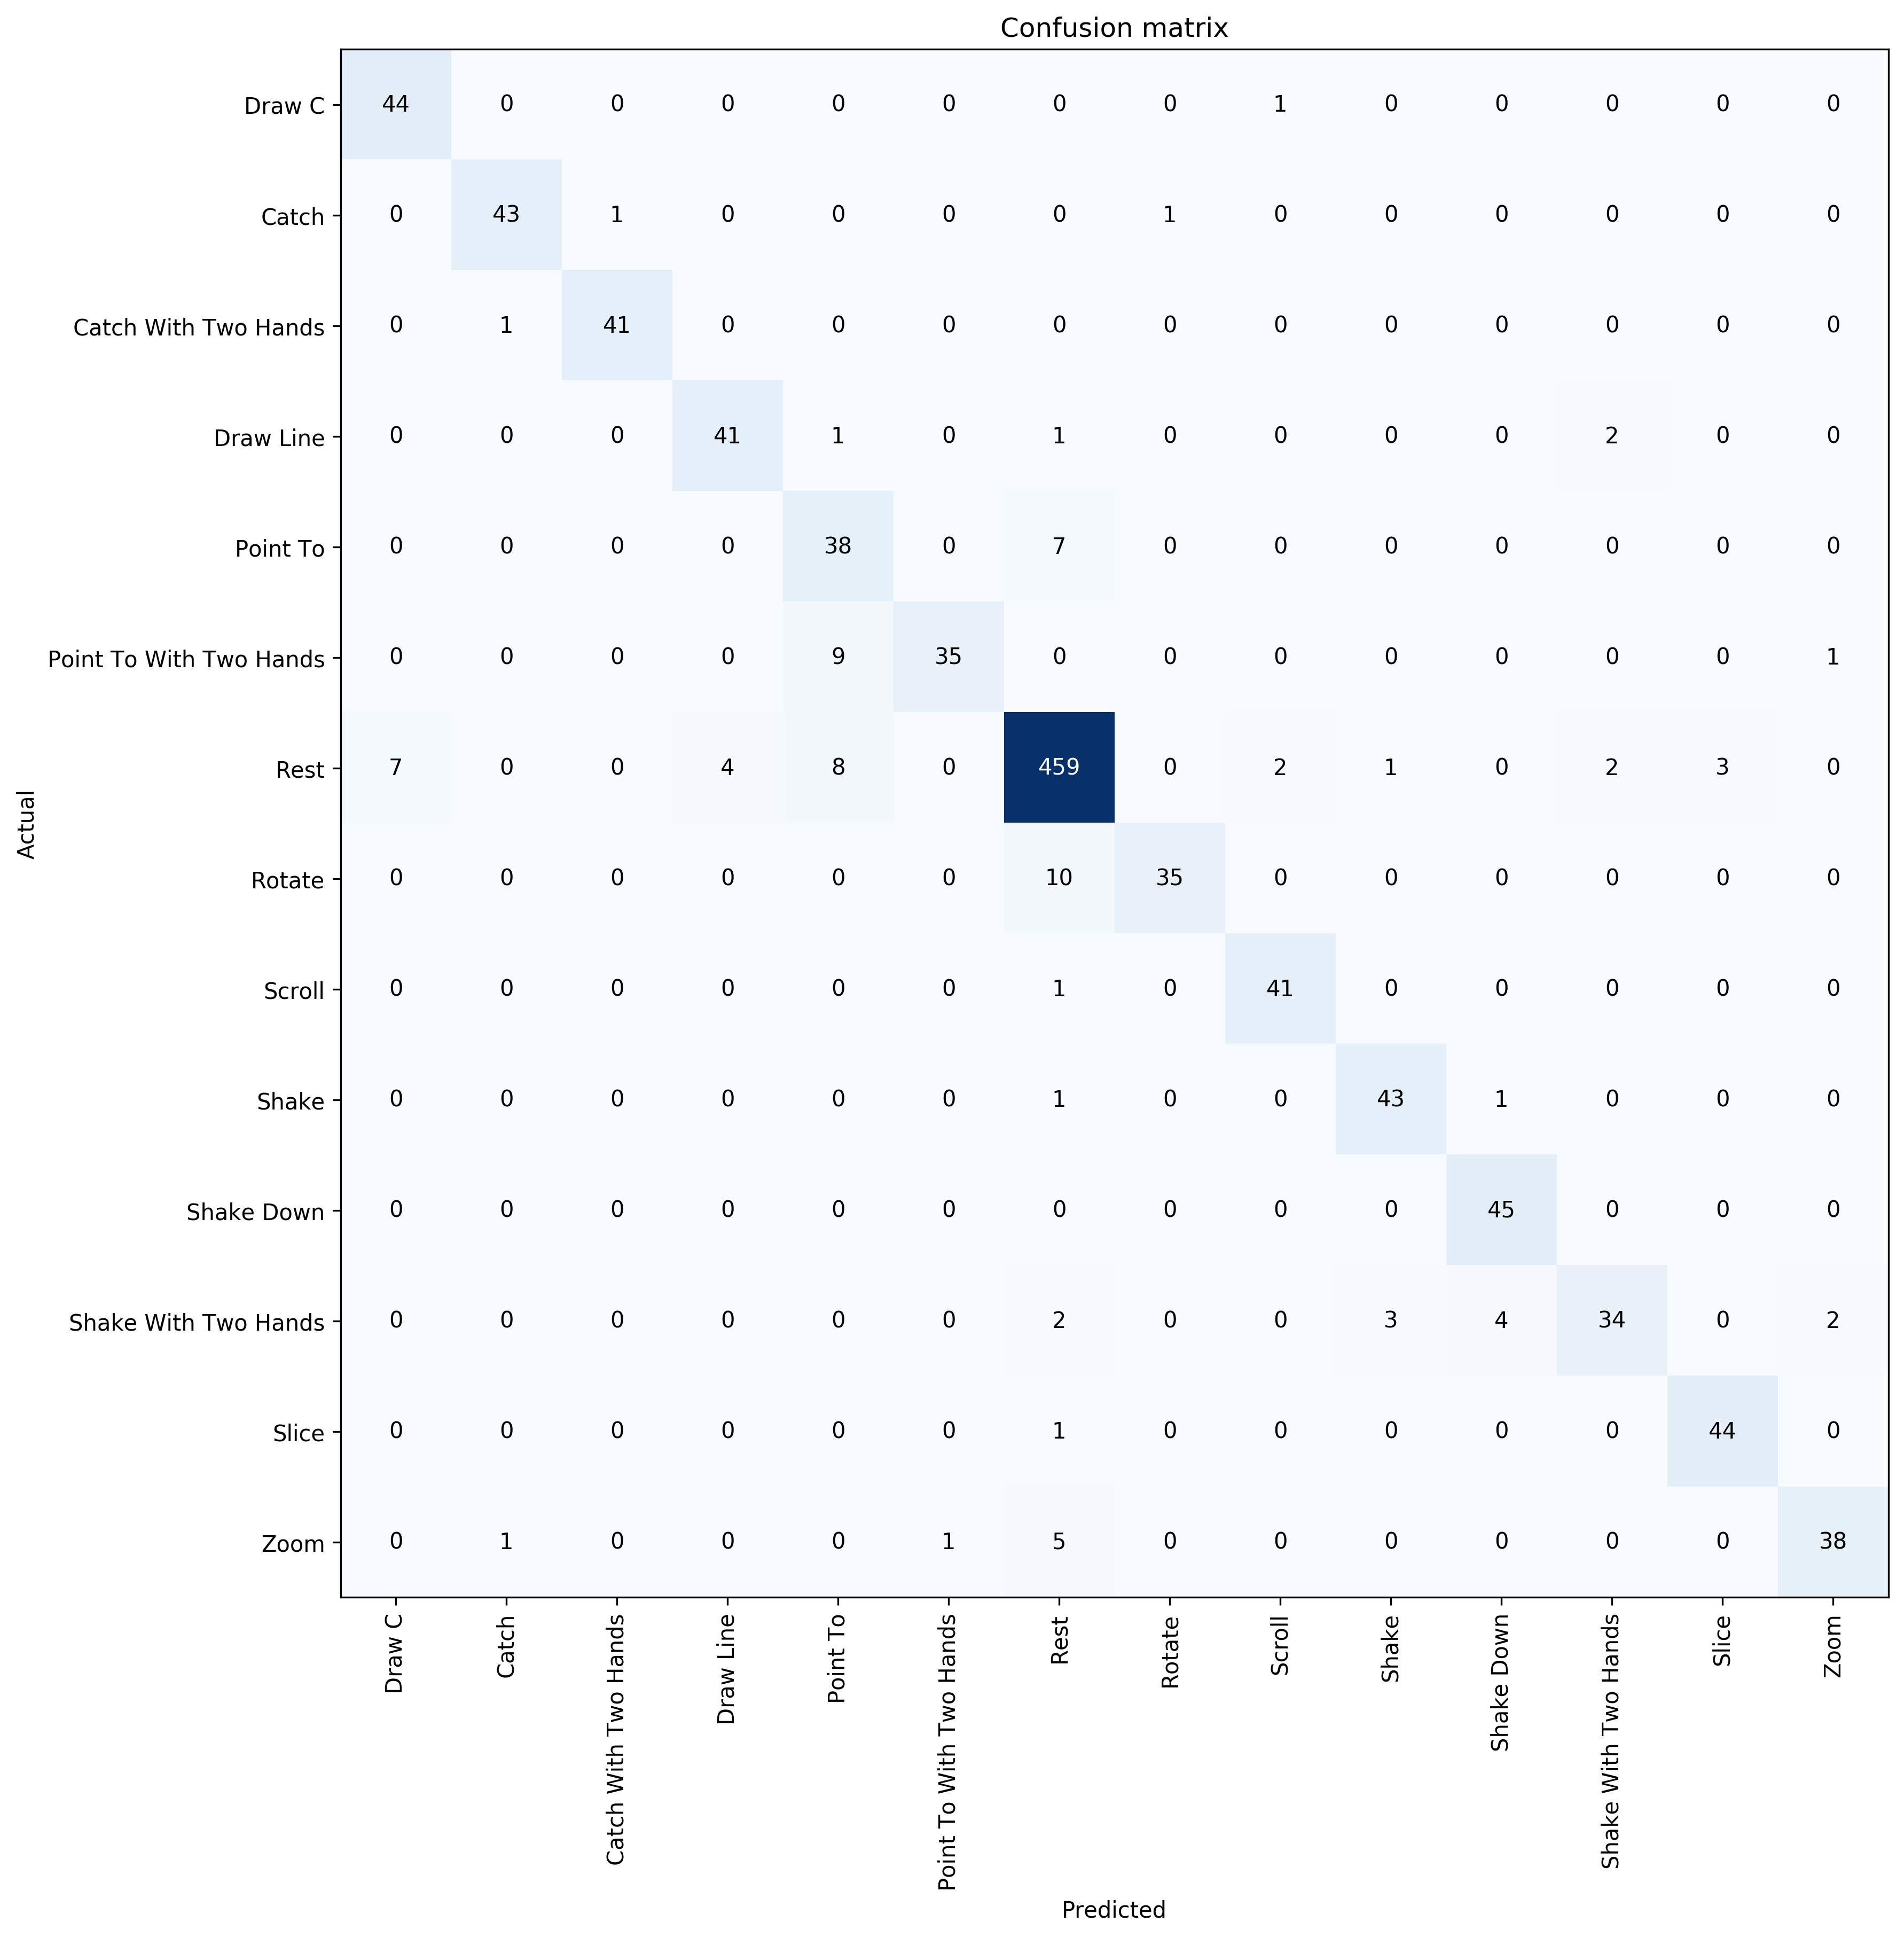

In [71]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-3


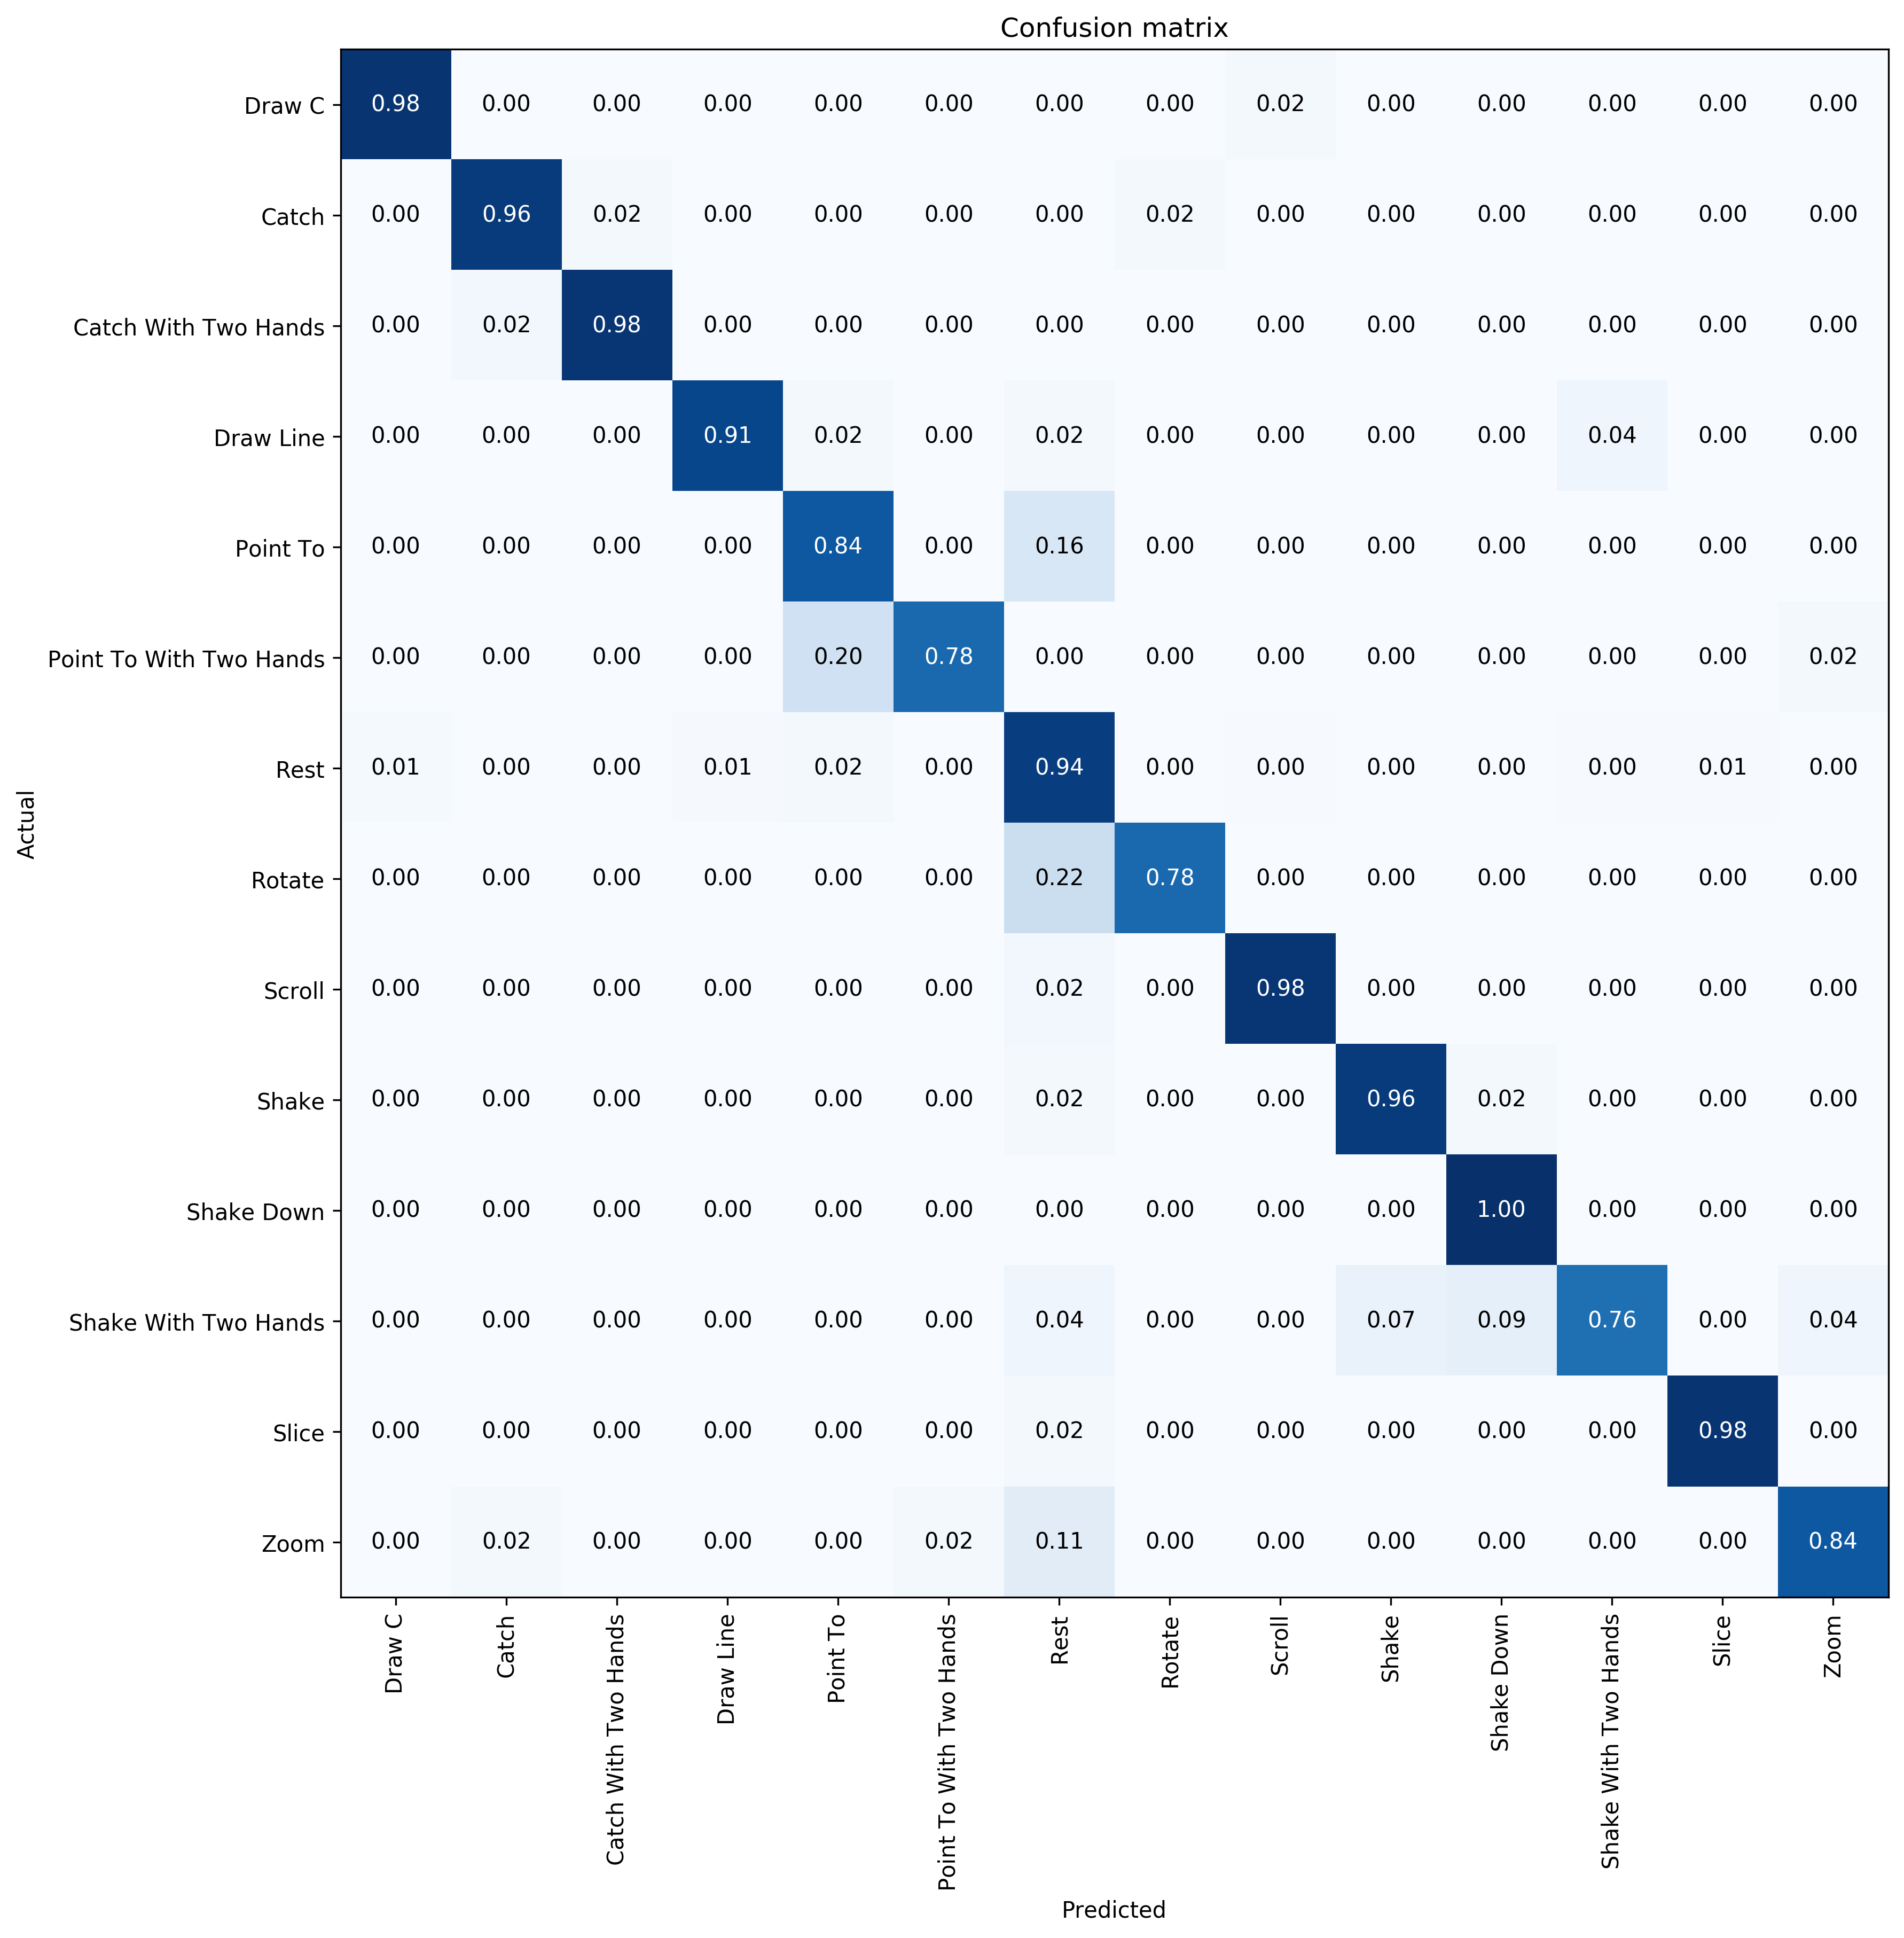

In [72]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [73]:
acc = evaluate_model_from_interp(interp, data)

Interp has 1065 ground truth labels: tensor([ 0,  0,  0,  ..., 13, 13, 13])
Interp yielded 1065 raw predictions. First two raw predictions are: tensor([[9.9999e-01, 2.5515e-07, 4.7819e-07, 4.7521e-07, 2.0474e-07, 5.7156e-08,
         8.6628e-07, 1.4961e-08, 6.7907e-06, 6.5073e-08, 8.0907e-08, 2.9694e-07,
         7.8638e-09, 5.2595e-08],
        [9.9978e-01, 7.2124e-05, 1.4130e-05, 1.4293e-05, 5.0794e-06, 2.3146e-08,
         9.0299e-05, 1.2972e-08, 2.1362e-05, 2.2818e-07, 5.5098e-08, 4.1084e-08,
         5.0546e-07, 1.3918e-06]])
The problem had 14 classes: ['Draw C', 'Catch', 'Catch With Two Hands', 'Draw Line', 'Point To', 'Point To With Two Hands', 'Rest', 'Rotate', 'Scroll', 'Shake', 'Shake Down', 'Shake With Two Hands', 'Slice', 'Zoom']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 0 = Draw C -> C
0 -> 

6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
4 -> 6 = Point To -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Resting
6 -> 6 = Rest -> Rest

13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
6 -> 13 = Rest -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
6 -> 13 = Rest -> Zoom
13 -> 13 = Zoom -> Zoom
6 -> 13 = Rest -> Zoom
1 -> 13 = Catch -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
5 -> 13 = Point To With Two Hands -> Zoom
13 -> 13 = Zoom -> Zoom
13 -> 13 = Zoom -> Zoom
6 -> 13 = Rest -> Zoom
13 -> 13 = Zoom -> Zoom
Overall accuracy of the model: 0.92113


In [74]:
learn.export(savepath / ('resnet-50-img_size-576x324-3b-20200220-163647-epoch-9-double-view-stronger-data-augmentation-92.11-perc-accuracy' + '.pkl')) # export model as pickle file to be used "outside fast.ai"